<a href="https://colab.research.google.com/github/Tongwu18/fu-yao/blob/main/Halle_4_RL%20%E6%AD%A3%E5%BC%8F%E7%89%88%E6%9C%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 数据清洗

In [5]:
import pandas as pd
import numpy as np
import gymnasium as gym
from gymnasium import spaces
from typing import List, Tuple, Optional, Dict, Any
from dataclasses import dataclass, field
import copy
df = pd.read_excel("https://github.com/Tongwu18/fu-yao/raw/main/Halle4.xlsx")
df

,本厂编号,类型,长,宽,高,体积,备注
0,00218LDR03012,LDR,1700,1140,1220,2.36436,NaN
1,00218LDR03012,LDR,1700,1140,1220,2.36436,NaN
2,00218LDR04012,LDR,1700,1140,1220,2.36436,NaN
3,00218LDR04012,LDR,1700,1140,1220,2.36436,NaN
4,00322TDR03001,TDR,1700,1140,1220,2.36436,转laichingen
...,...,...,...,...,...,...,...
4908,00604TDR06103-A01,TDR,1210,810,1000,0.98010,NaN
4909,00604TDR06103-A01,TDR,1210,810,1000,0.98010,NaN
4910,00604TDR06103-A01,TDR,1210,810,1000,0.98010,NaN
4911,00604TDR06103-A01,TDR,1210,810,1000,0.98010,NaN


In [6]:
"""
玻璃数据清洗
1. 本厂编号 → 数字ID
2. 按编号分组计数
3. 输出清洗后的工作表
"""

import pandas as pd
import numpy as np


def clean_glass_data(df, output_file="cleaned_glass_data.xlsx"):
    """
    清洗玻璃数据

    输入列: 本厂编号, 类型, 长, 宽, 高, 体积, 备注
    输出列: 玻璃ID, 本厂编号, 类型, 长, 宽, 长宽最大值, 高, 体积, 备注, 数量
    """
    print("="*60)
    print("Data Cleaning")
    print("="*60)

    print(f"\nRaw data: {len(df)} rows")
    print(f"Original columns: {df.columns.tolist()}")

    # 清理列名：去除空格
    df.columns = df.columns.str.strip()
    print(f"Cleaned columns: {df.columns.tolist()}")

    # 检测列名（支持多种可能的名称）
    id_col = next((c for c in df.columns if '编号' in c or 'ID' in c.upper()), None)
    type_col = next((c for c in df.columns if '类型' in c or 'type' in c.lower()), None)
    len_col = next((c for c in df.columns if c in ['长', '长度', 'length']), None)
    w_col = next((c for c in df.columns if c in ['宽', '宽度', 'width']), None)
    h_col = next((c for c in df.columns if c in ['高', '高度', 'height']), None)
    vol_col = next((c for c in df.columns if '体积' in c or 'volume' in c.lower()), None)
    note_col = next((c for c in df.columns if '备注' in c or 'note' in c.lower() or 'remark' in c.lower()), None)

    print(f"\nDetected: ID={id_col}, Type={type_col}, Length={len_col}, Width={w_col}, Height={h_col}, Volume={vol_col}, Note={note_col}")

    if id_col is None:
        raise ValueError("Cannot find ID column!")

    # 处理备注列：NaN→0, 转laichingen→1
    if note_col:
        df[note_col] = df[note_col].fillna(0)
        df[note_col] = df[note_col].apply(lambda x: 1 if isinstance(x, str) and 'laichingen' in x.lower() else (x if x != 0 else 0))
        print(f"\nNote column processed: NaN→0, laichingen→1")
        print(f"  Note=0 (Local): {(df[note_col] == 0).sum()} items")
        print(f"  Note=1 (Transfer): {(df[note_col] == 1).sum()} items")

    # 添加长宽最大值列（防止叉车倾倒）
    if len_col and w_col:
        df['MaxLW'] = df[[len_col, w_col]].max(axis=1)
        print(f"\nAdded MaxLW column (max of Length and Width) for forklift safety")

    # 按本厂编号分组
    agg_cols = {}
    if type_col: agg_cols[type_col] = 'first'
    if len_col: agg_cols[len_col] = 'first'
    if w_col: agg_cols[w_col] = 'first'
    if 'MaxLW' in df.columns: agg_cols['MaxLW'] = 'first'
    if h_col: agg_cols[h_col] = 'first'
    if vol_col: agg_cols[vol_col] = 'first'
    if note_col: agg_cols[note_col] = 'first'

    grouped = df.groupby(id_col).agg(agg_cols).reset_index()
    grouped['Count'] = df.groupby(id_col).size().values
    grouped = grouped.rename(columns={id_col: 'PartNo'})

    # 标准化列名为英文
    rename_map = {}
    if type_col: rename_map[type_col] = 'Type'
    if len_col: rename_map[len_col] = 'Length'
    if w_col: rename_map[w_col] = 'Width'
    if h_col: rename_map[h_col] = 'Height'
    if vol_col: rename_map[vol_col] = 'Volume'
    if note_col: rename_map[note_col] = 'Note'
    grouped = grouped.rename(columns=rename_map)

    # 创建数字ID，按数量排序
    grouped = grouped.sort_values('Count', ascending=False).reset_index(drop=True)
    grouped.insert(0, 'GlassID', range(1, len(grouped) + 1))

    print(f"\nCleaned: {len(grouped)} glass types")
    print(f"Total boxes: {grouped['Count'].sum()}")

    # 统计信息
    if 'MaxLW' in grouped.columns and 'Height' in grouped.columns:
        print(f"\nDimension range:")
        print(f"  MaxLW: {grouped['MaxLW'].min()} - {grouped['MaxLW'].max()} mm")
        print(f"  Height: {grouped['Height'].min()} - {grouped['Height'].max()} mm")

    if 'Note' in grouped.columns:
        print(f"\nNote stats:")
        print(f"  Transfer(=1): {(grouped['Note'] == 1).sum()} types, {grouped[grouped['Note']==1]['Count'].sum()} boxes")
        print(f"  Local(=0): {(grouped['Note'] == 0).sum()} types, {grouped[grouped['Note']==0]['Count'].sum()} boxes")

    print(f"\nQuantity distribution:")
    print(f"  Max: {grouped['Count'].max()} boxes")
    print(f"  Min: {grouped['Count'].min()} boxes")
    print(f"  Avg: {grouped['Count'].mean():.1f} boxes")

    print(f"\nTop 10 glass types:")
    print("-"*90)
    for _, row in grouped.head(10).iterrows():
        size_str = f"MaxLW={row.get('MaxLW', '?')}, H={row.get('Height', '?')}"
        note_str = f"Note={row.get('Note', '-')}"
        print(f"  ID={row['GlassID']:3d} | {row['PartNo']} | {size_str}mm | {row['Count']} boxes | {note_str}")

    # 保存
    grouped.to_excel(output_file, index=False)
    print(f"\nSaved: {output_file}")

    return grouped


def split_by_location(df_clean, output_all="all_glass.xlsx", output_local="local_glass.xlsx"):
    """
    Split by Note: All data vs Local data (Note=0)
    """
    print("\n" + "="*60)
    print("Split Output")
    print("="*60)

    # All data
    df_all = df_clean.copy()
    df_all.to_excel(output_all, index=False)
    print(f"\nAll data: {len(df_all)} types, {df_all['Count'].sum()} boxes -> {output_all}")

    # Local data (Note=0)
    df_local = df_clean[df_clean['Note'] == 0].copy()
    df_local['GlassID'] = range(1, len(df_local) + 1)
    df_local.to_excel(output_local, index=False)
    print(f"Local data: {len(df_local)} types, {df_local['Count'].sum()} boxes -> {output_local}")

    return df_all, df_local


def plot_glass_analysis(df, title_prefix="All", save_prefix="all"):
    """
    Plot glass data analysis charts (English)
    """
    import matplotlib.pyplot as plt
    import seaborn as sns

    sns.set_theme(style="whitegrid")
    plt.rcParams['font.sans-serif'] = ['DejaVu Sans', 'Arial']
    plt.rcParams['axes.unicode_minus'] = False

    fig, axes = plt.subplots(2, 3, figsize=(16, 10))
    fig.suptitle(f'{title_prefix} Glass Data Analysis (n={len(df)}, total={df["Count"].sum()} boxes)',
                 fontsize=14, fontweight='bold')

    # 1. MaxLW Distribution (用MaxLW代替Length)
    ax1 = axes[0, 0]
    sns.histplot(data=df, x='MaxLW', weights='Count', bins=30, kde=True, ax=ax1, color='steelblue')
    ax1.set_xlabel('Max(Length, Width) (mm)')
    ax1.set_ylabel('Box Count')
    ax1.set_title('MaxLW Distribution (weighted)')

    # 2. Height Distribution
    ax2 = axes[0, 1]
    sns.histplot(data=df, x='Height', weights='Count', bins=30, kde=True, ax=ax2, color='coral')
    ax2.set_xlabel('Height (mm)')
    ax2.set_ylabel('Box Count')
    ax2.set_title('Height Distribution (weighted)')

    # 3. Volume Distribution
    ax3 = axes[0, 2]
    sns.histplot(data=df, x='Volume', weights='Count', bins=30, kde=True, ax=ax3, color='green')
    ax3.set_xlabel('Volume (m³)')
    ax3.set_ylabel('Box Count')
    ax3.set_title('Volume Distribution (weighted)')

    # 4. Type Distribution
    ax4 = axes[1, 0]
    type_counts = df.groupby('Type')['Count'].sum().sort_values(ascending=True)
    colors = sns.color_palette('Set2', len(type_counts))
    bars = ax4.barh(type_counts.index, type_counts.values, color=colors)
    ax4.set_xlabel('Box Count')
    ax4.set_ylabel('Type')
    ax4.set_title('Type Distribution')
    for bar, val in zip(bars, type_counts.values):
        ax4.text(val + 10, bar.get_y() + bar.get_height()/2, f'{val}', va='center', fontsize=9)

    # 5. MaxLW vs Height Scatter (用MaxLW代替Length)
    ax5 = axes[1, 1]
    scatter = ax5.scatter(df['MaxLW'], df['Height'], s=df['Count']*5, c=df['Volume'],
                          cmap='viridis', alpha=0.6, edgecolors='black', linewidth=0.5)
    ax5.set_xlabel('Max(Length, Width) (mm)')
    ax5.set_ylabel('Height (mm)')
    ax5.set_title('MaxLW vs Height (size=count, color=volume)')
    plt.colorbar(scatter, ax=ax5, label='Volume')

    # 6. Quantity Distribution
    ax6 = axes[1, 2]
    sns.histplot(data=df, x='Count', bins=30, kde=True, ax=ax6, color='purple')
    ax6.set_xlabel('Boxes per Glass Type')
    ax6.set_ylabel('Glass Type Count')
    ax6.set_title('Quantity Distribution per Type')
    ax6.axvline(df['Count'].mean(), color='red', linestyle='--', label=f'Mean={df["Count"].mean():.1f}')
    ax6.legend()

    plt.tight_layout()
    filename = f'{save_prefix}_glass_analysis.png'
    plt.savefig(filename, dpi=150, bbox_inches='tight', facecolor='white')
    plt.show()
    print(f"\nChart saved: {filename}")

    return fig


def full_clean_and_plot(df, output_prefix="glass"):
    """
    Full workflow: Clean -> Split -> Plot
    """
    # 1. Clean
    df_clean = clean_glass_data(df, f"{output_prefix}_cleaned.xlsx")

    # 2. Split
    df_all, df_local = split_by_location(
        df_clean,
        f"{output_prefix}_all.xlsx",
        f"{output_prefix}_local.xlsx"
    )

    # 3. Plot
    print("\n" + "="*60)
    print("Generating Charts")
    print("="*60)

    plot_glass_analysis(df_all, "All Data", f"{output_prefix}_all")
    plot_glass_analysis(df_local, "Local Only (Note=0)", f"{output_prefix}_local")

    return df_clean, df_all, df_local


def quick_clean(filepath, output_file="cleaned_glass_data.xlsx"):
    """
    快速清洗（一键）
    """
    df = pd.read_excel(filepath)
    return clean_glass_data(df, output_file)


if __name__ == "__main__":
    print("""
用法:
    import pandas as pd
    from data_cleaner import clean_glass_data, quick_clean

    # 方式1: 直接从文件
    df_clean = quick_clean("原始数据.xlsx", "清洗后数据.xlsx")

    # 方式2: 从DataFrame
    df = pd.read_excel("原始数据.xlsx")
    df_clean = clean_glass_data(df, "清洗后数据.xlsx")
    """)


用法:
    import pandas as pd
    from data_cleaner import clean_glass_data, quick_clean
    
    # 方式1: 直接从文件
    df_clean = quick_clean("原始数据.xlsx", "清洗后数据.xlsx")
    
    # 方式2: 从DataFrame
    df = pd.read_excel("原始数据.xlsx")
    df_clean = clean_glass_data(df, "清洗后数据.xlsx")
    


Data Cleaning

Raw data: 4913 rows
Original columns: ['本厂编号        ', '类型', '长', '宽', '高', '体积', '备注']
Cleaned columns: ['本厂编号', '类型', '长', '宽', '高', '体积', '备注']

Detected: ID=本厂编号, Type=类型, Length=长, Width=宽, Height=高, Volume=体积, Note=备注

Note column processed: NaN→0, laichingen→1
  Note=0 (Local): 4427 items
  Note=1 (Transfer): 486 items

Added MaxLW column (max of Length and Width) for forklift safety

Cleaned: 800 glass types
Total boxes: 4913

Dimension range:
  MaxLW: 600 - 2280 mm
  Height: 415 - 1600 mm

Note stats:
  Transfer(=1): 48 types, 486 boxes
  Local(=0): 752 types, 4427 boxes

Quantity distribution:
  Max: 71 boxes
  Min: 1 boxes
  Avg: 6.1 boxes

Top 10 glass types:
------------------------------------------------------------------------------------------
  ID=  1 | 00514TDR06004 | MaxLW=1700, H=1220mm | 71 boxes | Note=0
  ID=  2 | 00514TDR05004 | MaxLW=1700, H=1220mm | 65 boxes | Note=0
  ID=  3 | 00718LFW00022 | MaxLW=1700, H=1220mm | 51 boxes | Note=0
  ID=  4 |

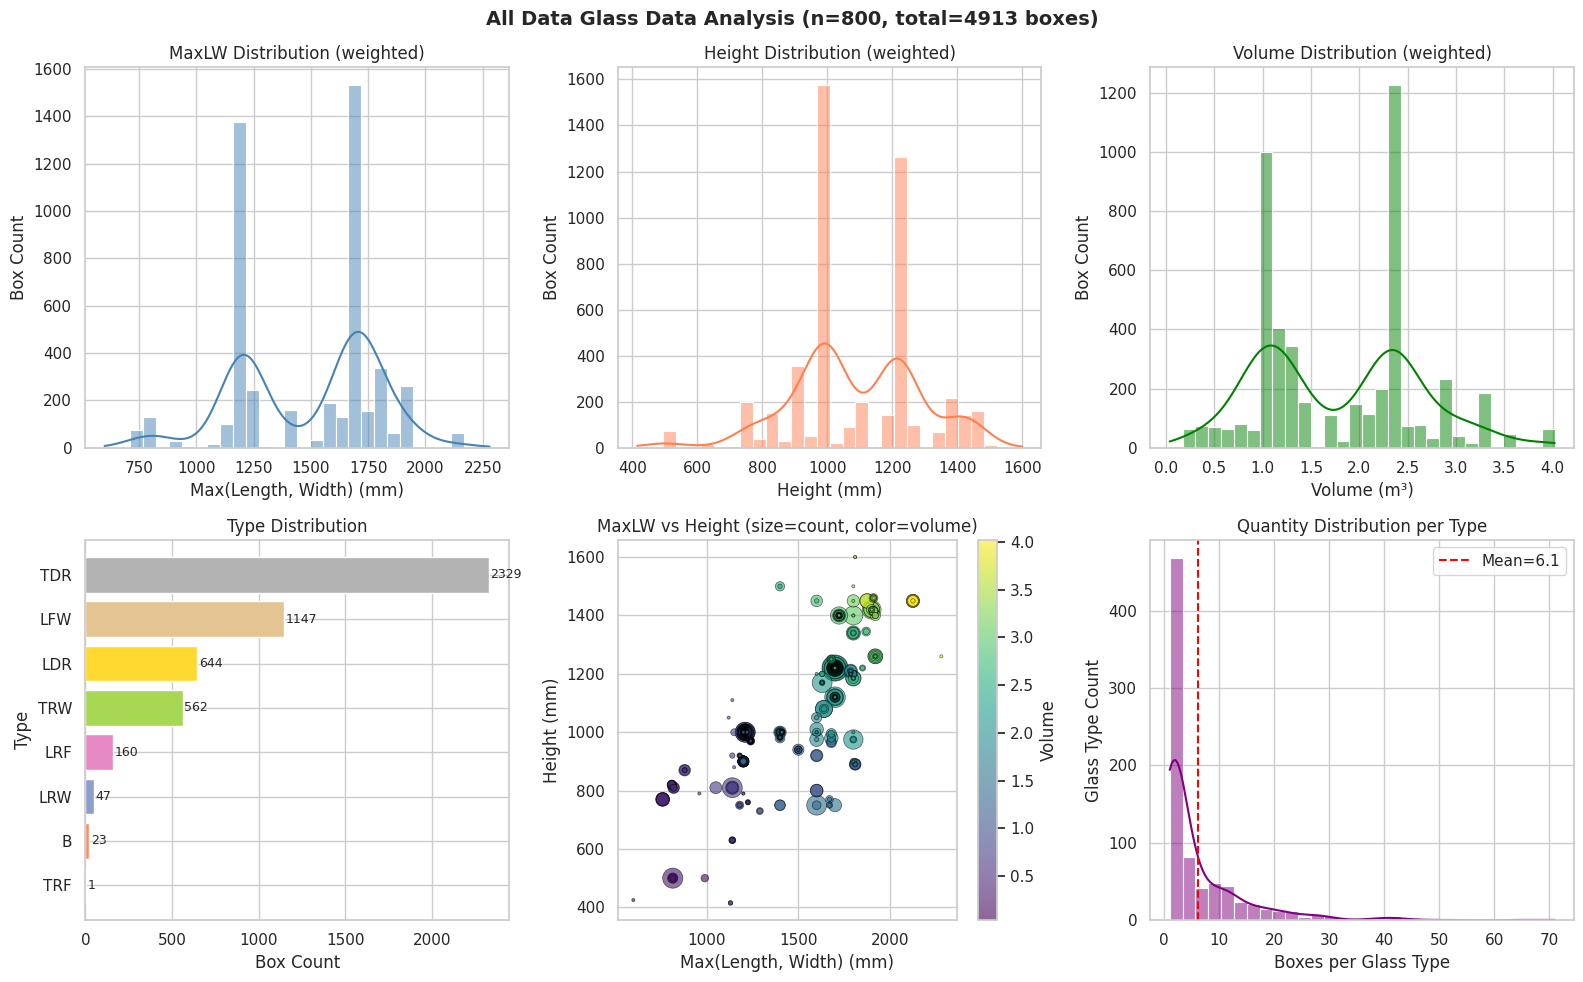


Chart saved: glass_all_glass_analysis.png


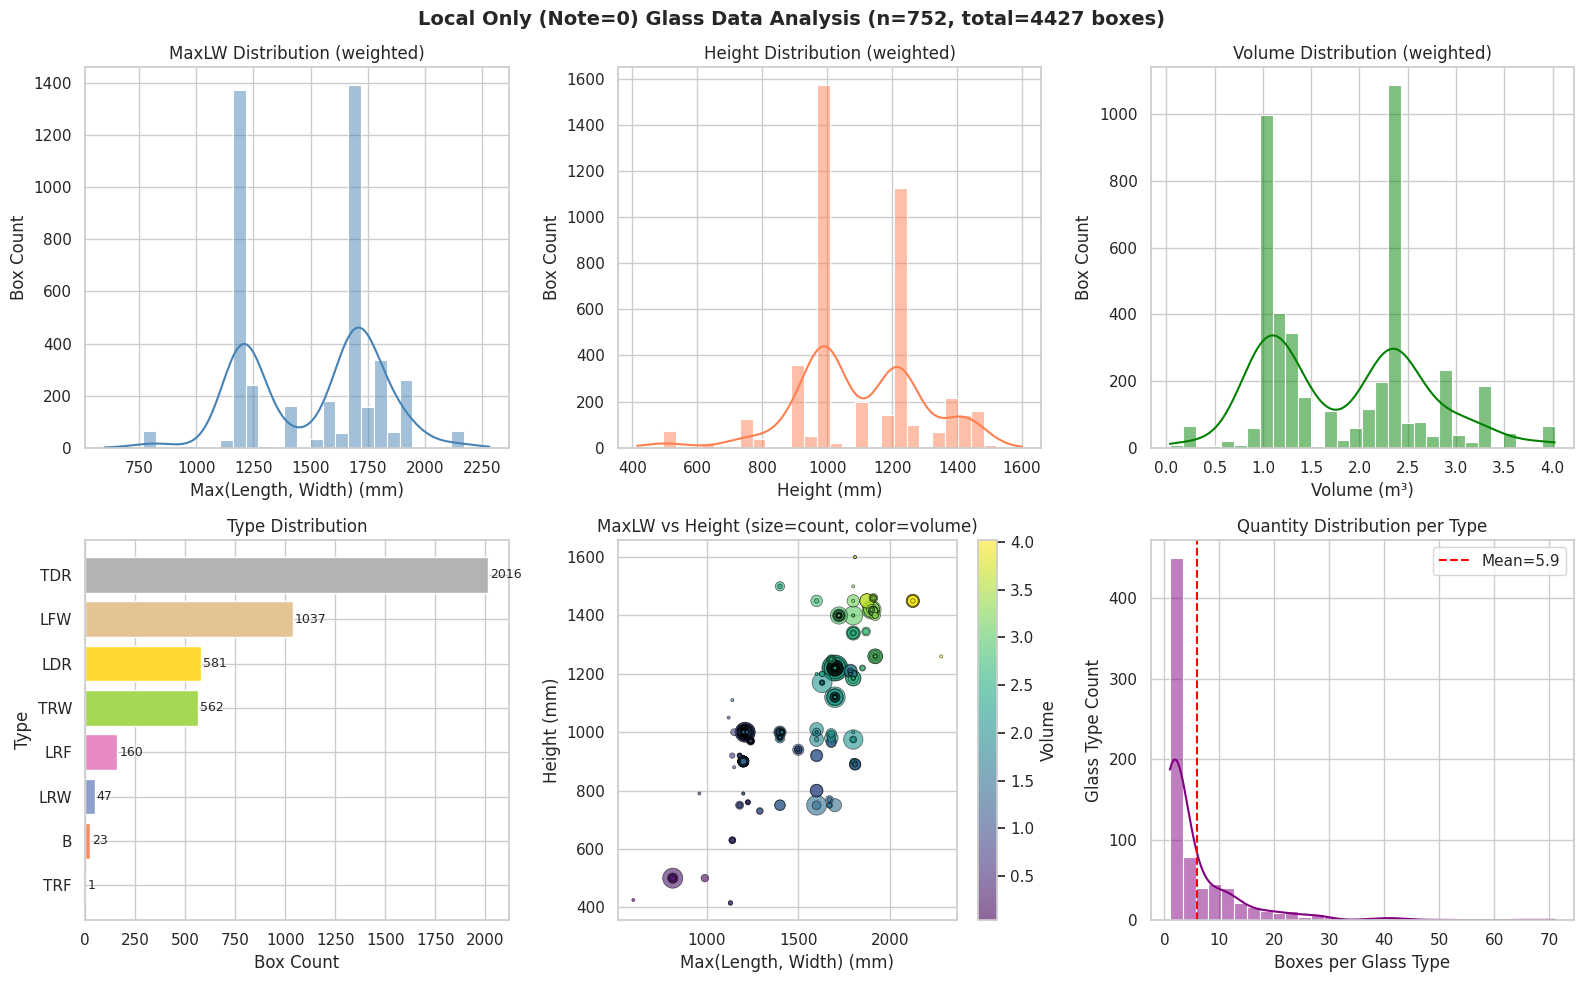


Chart saved: glass_local_glass_analysis.png


,GlassID,PartNo,Type,Length,Width,MaxLW,Height,Volume,Note,Count
0,1,00514TDR06004,TDR,1700,1140,1700,1220,2.36436,0,71
1,2,00514TDR05004,TDR,1700,1140,1700,1220,2.36436,0,65
2,3,00718LFW00022,LFW,1700,1140,1700,1220,2.36436,0,51
3,4,00296LDR06011,LDR,1700,1140,1700,1220,2.36436,0,46
4,5,89650TRW00009,TRW,1700,1140,1700,1120,2.17056,0,44


In [7]:
df_clean, df_all, df_local = full_clean_and_plot(df, output_prefix="glass")
df_clean.head()

# 聚类分析


In [8]:
"""
Glass Clustering Analysis
- Cluster by: MaxLW, Height (Type is just reference, not for clustering)
- Use Elbow method to find optimal cluster number
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score


def prepare_features(df):
    """
    Prepare features for clustering: MaxLW, Height only
    (Type is reference only, not used in clustering)
    """
    # Features for clustering (only MaxLW and Height)
    features = df[['MaxLW', 'Height']].copy()

    # Standardize features
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    print(f"Features prepared: MaxLW, Height")
    print(f"  MaxLW range: {df['MaxLW'].min()} - {df['MaxLW'].max()} mm")
    print(f"  Height range: {df['Height'].min()} - {df['Height'].max()} mm")
    print(f"  (Type is reference only, not used in clustering)")

    return features_scaled, scaler


def elbow_analysis(features_scaled, k_range=range(2, 21), title="All Data"):
    """
    Elbow method to find optimal K
    """
    print(f"\n{'='*60}")
    print(f"Elbow Analysis - {title}")
    print(f"{'='*60}")

    inertias = []
    silhouettes = []

    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(features_scaled)
        inertias.append(kmeans.inertia_)

        sil_score = silhouette_score(features_scaled, kmeans.labels_)
        silhouettes.append(sil_score)

        print(f"  K={k:2d}: Inertia={kmeans.inertia_:,.0f}, Silhouette={sil_score:.3f}")

    return list(k_range), inertias, silhouettes


def find_elbow_point(k_range, inertias):
    """
    Find elbow point using the kneedle algorithm (simplified)
    """
    # Normalize
    k_norm = (np.array(k_range) - min(k_range)) / (max(k_range) - min(k_range))
    inertia_norm = (np.array(inertias) - min(inertias)) / (max(inertias) - min(inertias))

    # Find point with maximum distance to line from first to last
    p1 = np.array([k_norm[0], inertia_norm[0]])
    p2 = np.array([k_norm[-1], inertia_norm[-1]])

    distances = []
    for i in range(len(k_range)):
        p = np.array([k_norm[i], inertia_norm[i]])
        # Distance from point to line
        d = np.abs(np.cross(p2-p1, p1-p)) / np.linalg.norm(p2-p1)
        distances.append(d)

    elbow_idx = np.argmax(distances)
    return k_range[elbow_idx]


def plot_elbow(k_range, inertias, silhouettes, title="All Data", save_prefix="all"):
    """
    Plot Elbow curve and Silhouette score
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    fig.suptitle(f'Clustering Analysis - {title}', fontsize=14, fontweight='bold')

    # Find elbow point
    elbow_k = find_elbow_point(k_range, inertias)

    # 1. Elbow curve (Inertia)
    ax1 = axes[0]
    ax1.plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
    ax1.set_xlabel('Number of Clusters (K)')
    ax1.set_ylabel('Inertia (Within-cluster sum of squares)')
    ax1.set_title('Elbow Method')
    ax1.grid(True, alpha=0.3)
    ax1.axvline(x=elbow_k, color='red', linestyle='--', label=f'Elbow at K={elbow_k}')
    ax1.legend()

    # 2. Silhouette score
    ax2 = axes[1]
    ax2.plot(k_range, silhouettes, 'go-', linewidth=2, markersize=8)
    ax2.set_xlabel('Number of Clusters (K)')
    ax2.set_ylabel('Silhouette Score')
    ax2.set_title('Silhouette Analysis')
    ax2.grid(True, alpha=0.3)

    # Best silhouette
    best_sil_idx = np.argmax(silhouettes)
    best_sil_k = k_range[best_sil_idx]
    ax2.axvline(x=best_sil_k, color='red', linestyle='--', label=f'Best at K={best_sil_k}')
    ax2.legend()

    plt.tight_layout()
    filename = f'{save_prefix}_elbow_analysis.png'
    plt.savefig(filename, dpi=150, bbox_inches='tight', facecolor='white')
    plt.show()

    print(f"\nElbow point: K={elbow_k}")
    print(f"Best Silhouette: K={best_sil_k} (score={silhouettes[best_sil_idx]:.3f})")
    print(f"Chart saved: {filename}")

    return elbow_k, best_sil_k


def cluster_glass(df, n_clusters, features_scaled):
    """
    Perform clustering with specified K
    """
    print(f"\n{'='*60}")
    print(f"Clustering with K={n_clusters}")
    print(f"{'='*60}")

    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    df_result = df.copy()
    df_result['Cluster'] = kmeans.fit_predict(features_scaled)

    # Get cluster centers (in original scale)
    centers = kmeans.cluster_centers_

    # Cluster statistics
    print(f"\nCluster Statistics:")
    print("-"*80)

    cluster_stats = []
    for c in range(n_clusters):
        cluster_df = df_result[df_result['Cluster'] == c]
        stats = {
            'Cluster': c,
            'Count_Types': len(cluster_df),
            'Count_Boxes': cluster_df['Count'].sum(),
            'MaxLW_min': cluster_df['MaxLW'].min(),
            'MaxLW_max': cluster_df['MaxLW'].max(),
            'MaxLW_mean': cluster_df['MaxLW'].mean(),
            'Height_min': cluster_df['Height'].min(),
            'Height_max': cluster_df['Height'].max(),
            'Height_mean': cluster_df['Height'].mean(),
            'Types': cluster_df['Type'].value_counts().to_dict() if 'Type' in cluster_df.columns else {}
        }
        cluster_stats.append(stats)

        print(f"\nCluster {c}:")
        print(f"  Glass types: {stats['Count_Types']}, Total boxes: {stats['Count_Boxes']}")
        print(f"  MaxLW: {stats['MaxLW_min']:.0f} - {stats['MaxLW_max']:.0f} mm (mean: {stats['MaxLW_mean']:.0f})")
        print(f"  Height: {stats['Height_min']:.0f} - {stats['Height_max']:.0f} mm (mean: {stats['Height_mean']:.0f})")
        if stats['Types']:
            print(f"  Types: {stats['Types']}")

    return df_result, cluster_stats, kmeans


def plot_clusters(df_result, title="All Data", save_prefix="all"):
    """
    Visualize clustering results
    """
    n_clusters = df_result['Cluster'].nunique()

    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    fig.suptitle(f'Clustering Results - {title} (K={n_clusters})', fontsize=14, fontweight='bold')

    palette = sns.color_palette('tab10', n_clusters)

    # 1. MaxLW vs Height scatter (main plot)
    ax1 = axes[0, 0]
    for c in range(n_clusters):
        cluster_df = df_result[df_result['Cluster'] == c]
        ax1.scatter(cluster_df['MaxLW'], cluster_df['Height'],
                   s=cluster_df['Count']*5, alpha=0.6,
                   label=f'Cluster {c} (n={len(cluster_df)})', color=palette[c],
                   edgecolors='black', linewidth=0.3)
    ax1.set_xlabel('MaxLW (mm)')
    ax1.set_ylabel('Height (mm)')
    ax1.set_title('MaxLW vs Height by Cluster (size=box count)')
    ax1.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=8)
    ax1.grid(True, alpha=0.3)

    # 2. Cluster size (box count)
    ax2 = axes[0, 1]
    cluster_boxes = df_result.groupby('Cluster')['Count'].sum().sort_index()
    bars = ax2.bar(cluster_boxes.index, cluster_boxes.values, color=palette)
    ax2.set_xlabel('Cluster')
    ax2.set_ylabel('Total Boxes')
    ax2.set_title('Boxes per Cluster')
    for bar, val in zip(bars, cluster_boxes.values):
        ax2.text(bar.get_x() + bar.get_width()/2, val + 10, f'{val}', ha='center', fontsize=9)

    # 3. MaxLW distribution by cluster
    ax3 = axes[1, 0]
    for c in range(n_clusters):
        cluster_df = df_result[df_result['Cluster'] == c]
        ax3.hist(cluster_df['MaxLW'], bins=20, alpha=0.5, label=f'Cluster {c}', color=palette[c])
    ax3.set_xlabel('MaxLW (mm)')
    ax3.set_ylabel('Count')
    ax3.set_title('MaxLW Distribution by Cluster')
    ax3.legend()

    # 4. Height distribution by cluster
    ax4 = axes[1, 1]
    for c in range(n_clusters):
        cluster_df = df_result[df_result['Cluster'] == c]
        ax4.hist(cluster_df['Height'], bins=20, alpha=0.5, label=f'Cluster {c}', color=palette[c])
    ax4.set_xlabel('Height (mm)')
    ax4.set_ylabel('Count')
    ax4.set_title('Height Distribution by Cluster')
    ax4.legend()

    plt.tight_layout()
    filename = f'{save_prefix}_clusters.png'
    plt.savefig(filename, dpi=150, bbox_inches='tight', facecolor='white')
    plt.show()
    print(f"Chart saved: {filename}")

    return fig


def create_merged_specs(df_result, cluster_stats):
    """
    Create merged specifications based on clusters
    For packing: use MaxLW_max and Height_max of each cluster
    """
    print(f"\n{'='*60}")
    print("Merged Specifications for Packing")
    print("{'='*60}")

    merged_specs = []
    for stats in cluster_stats:
        spec = {
            'Cluster': stats['Cluster'],
            'Std_MaxLW': stats['MaxLW_max'],  # Use max for safety
            'Std_Height': stats['Height_max'],  # Use max for safety
            'Glass_Types': stats['Count_Types'],
            'Total_Boxes': stats['Count_Boxes'],
        }
        merged_specs.append(spec)
        print(f"Cluster {spec['Cluster']}: Std_MaxLW={spec['Std_MaxLW']:.0f}, Std_Height={spec['Std_Height']:.0f} "
              f"({spec['Glass_Types']} types, {spec['Total_Boxes']} boxes)")

    return pd.DataFrame(merged_specs)


def full_cluster_analysis(df, k_range=range(2, 21), title="All Data", save_prefix="all",
                          chosen_k=None):
    """
    Full clustering workflow:
    1. Prepare features (MaxLW, Height)
    2. Elbow analysis
    3. Cluster with optimal/chosen K
    4. Visualize results
    5. Create merged specs

    Args:
        df: DataFrame with MaxLW, Height, Count columns
        k_range: range of K values to test
        title: title for plots
        save_prefix: prefix for saved files
        chosen_k: if specified, use this K instead of elbow point

    Returns:
        df_result: DataFrame with Cluster column added
        cluster_stats: list of cluster statistics
        merged_specs: DataFrame of merged specifications
    """
    print(f"\n{'='*60}")
    print(f"Full Cluster Analysis - {title}")
    print(f"{'='*60}")
    print(f"Data: {len(df)} glass types, {df['Count'].sum()} boxes")

    # 1. Prepare features
    features_scaled, scaler = prepare_features(df)

    # 2. Elbow analysis
    k_list, inertias, silhouettes = elbow_analysis(features_scaled, k_range, title)
    elbow_k, best_sil_k = plot_elbow(k_list, inertias, silhouettes, title, save_prefix)

    # 3. Choose K
    if chosen_k is None:
        optimal_k = elbow_k
        print(f"\nUsing elbow point K={optimal_k}")
    else:
        optimal_k = chosen_k
        print(f"\nUsing specified K={optimal_k}")

    # 4. Cluster
    df_result, cluster_stats, kmeans = cluster_glass(df, optimal_k, features_scaled)

    # 5. Visualize
    plot_clusters(df_result, title, save_prefix)

    # 6. Create merged specs
    merged_specs = create_merged_specs(df_result, cluster_stats)

    # 7. Save results
    df_result.to_excel(f'{save_prefix}_clustered.xlsx', index=False)
    merged_specs.to_excel(f'{save_prefix}_merged_specs.xlsx', index=False)
    print(f"\nSaved: {save_prefix}_clustered.xlsx")
    print(f"Saved: {save_prefix}_merged_specs.xlsx")

    return df_result, cluster_stats, merged_specs


# Quick function for both all and local data
def analyze_all_and_local(df_all, df_local, k_range=range(2, 21), chosen_k_all=None, chosen_k_local=None):
    """
    Run cluster analysis on both all data and local data
    """
    print("\n" + "="*80)
    print("CLUSTERING ANALYSIS")
    print("="*80)

    # All data
    result_all, stats_all, specs_all = full_cluster_analysis(
        df_all, k_range, "All Data", "all", chosen_k_all
    )

    # Local data
    result_local, stats_local, specs_local = full_cluster_analysis(
        df_local, k_range, "Local Only", "local", chosen_k_local
    )

    return {
        'all': {'result': result_all, 'stats': stats_all, 'specs': specs_all},
        'local': {'result': result_local, 'stats': stats_local, 'specs': specs_local}
    }


if __name__ == "__main__":
    print("""
Usage:
    from cluster_analysis import full_cluster_analysis, analyze_all_and_local

    # Single dataset analysis
    df_result, stats, merged_specs = full_cluster_analysis(
        df_local,
        k_range=range(2, 21),
        title="Local Data",
        save_prefix="local",
        chosen_k=None  # None = auto (elbow), or specify like chosen_k=8
    )

    # Both all and local
    results = analyze_all_and_local(df_all, df_local)
    """)


Usage:
    from cluster_analysis import full_cluster_analysis, analyze_all_and_local
    
    # Single dataset analysis
    df_result, stats, merged_specs = full_cluster_analysis(
        df_local, 
        k_range=range(2, 21),
        title="Local Data",
        save_prefix="local",
        chosen_k=None  # None = auto (elbow), or specify like chosen_k=8
    )
    
    # Both all and local
    results = analyze_all_and_local(df_all, df_local)
    



Full Cluster Analysis - Local Data
Data: 752 glass types, 4427 boxes
Features prepared: MaxLW, Height
  MaxLW range: 600 - 2280 mm
  Height range: 415 - 1600 mm
  (Type is reference only, not used in clustering)

Elbow Analysis - Local Data
  K= 2: Inertia=399, Silhouette=0.719
  K= 3: Inertia=283, Silhouette=0.697
  K= 4: Inertia=193, Silhouette=0.711
  K= 5: Inertia=124, Silhouette=0.732
  K= 6: Inertia=101, Silhouette=0.729
  K= 7: Inertia=83, Silhouette=0.737
  K= 8: Inertia=66, Silhouette=0.737
  K= 9: Inertia=56, Silhouette=0.744
  K=10: Inertia=50, Silhouette=0.760
  K=11: Inertia=41, Silhouette=0.754
  K=12: Inertia=35, Silhouette=0.775
  K=13: Inertia=32, Silhouette=0.780
  K=14: Inertia=29, Silhouette=0.782
  K=15: Inertia=24, Silhouette=0.785
  K=16: Inertia=22, Silhouette=0.792
  K=17: Inertia=19, Silhouette=0.810
  K=18: Inertia=17, Silhouette=0.815
  K=19: Inertia=15, Silhouette=0.833
  K=20: Inertia=13, Silhouette=0.837


/tmp/ipython-input-1660233363.py:76: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  d = np.abs(np.cross(p2-p1, p1-p)) / np.linalg.norm(p2-p1)


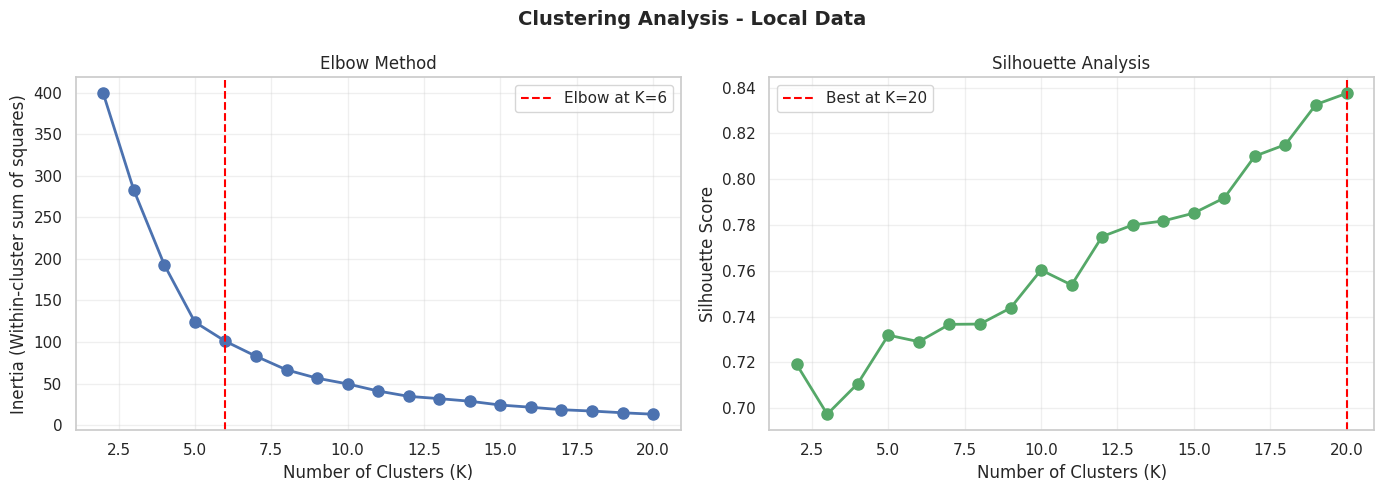


Elbow point: K=6
Best Silhouette: K=20 (score=0.837)
Chart saved: local_elbow_analysis.png

Using elbow point K=6

Clustering with K=6

Cluster Statistics:
--------------------------------------------------------------------------------

Cluster 0:
  Glass types: 8, Total boxes: 76
  MaxLW: 600 - 1130 mm (mean: 889)
  Height: 415 - 500 mm (mean: 469)
  Types: {'TDR': 5, 'LDR': 2, 'LRW': 1}

Cluster 1:
  Glass types: 42, Total boxes: 384
  MaxLW: 1500 - 1810 mm (mean: 1662)
  Height: 750 - 1010 mm (mean: 910)
  Types: {'TRW': 31, 'TDR': 7, 'LFW': 3, 'LRF': 1}

Cluster 2:
  Glass types: 283, Total boxes: 1564
  MaxLW: 1600 - 1920 mm (mean: 1710)
  Height: 1120 - 1260 mm (mean: 1205)
  Types: {'TDR': 102, 'LFW': 65, 'TRW': 51, 'LDR': 50, 'LRW': 7, 'B': 6, 'LRF': 2}

Cluster 3:
  Glass types: 314, Total boxes: 1731
  MaxLW: 1120 - 1410 mm (mean: 1231)
  Height: 880 - 1110 mm (mean: 984)
  Types: {'TDR': 250, 'LDR': 61, 'B': 2, 'LRF': 1}

Cluster 4:
  Glass types: 18, Total boxes: 70
  Max

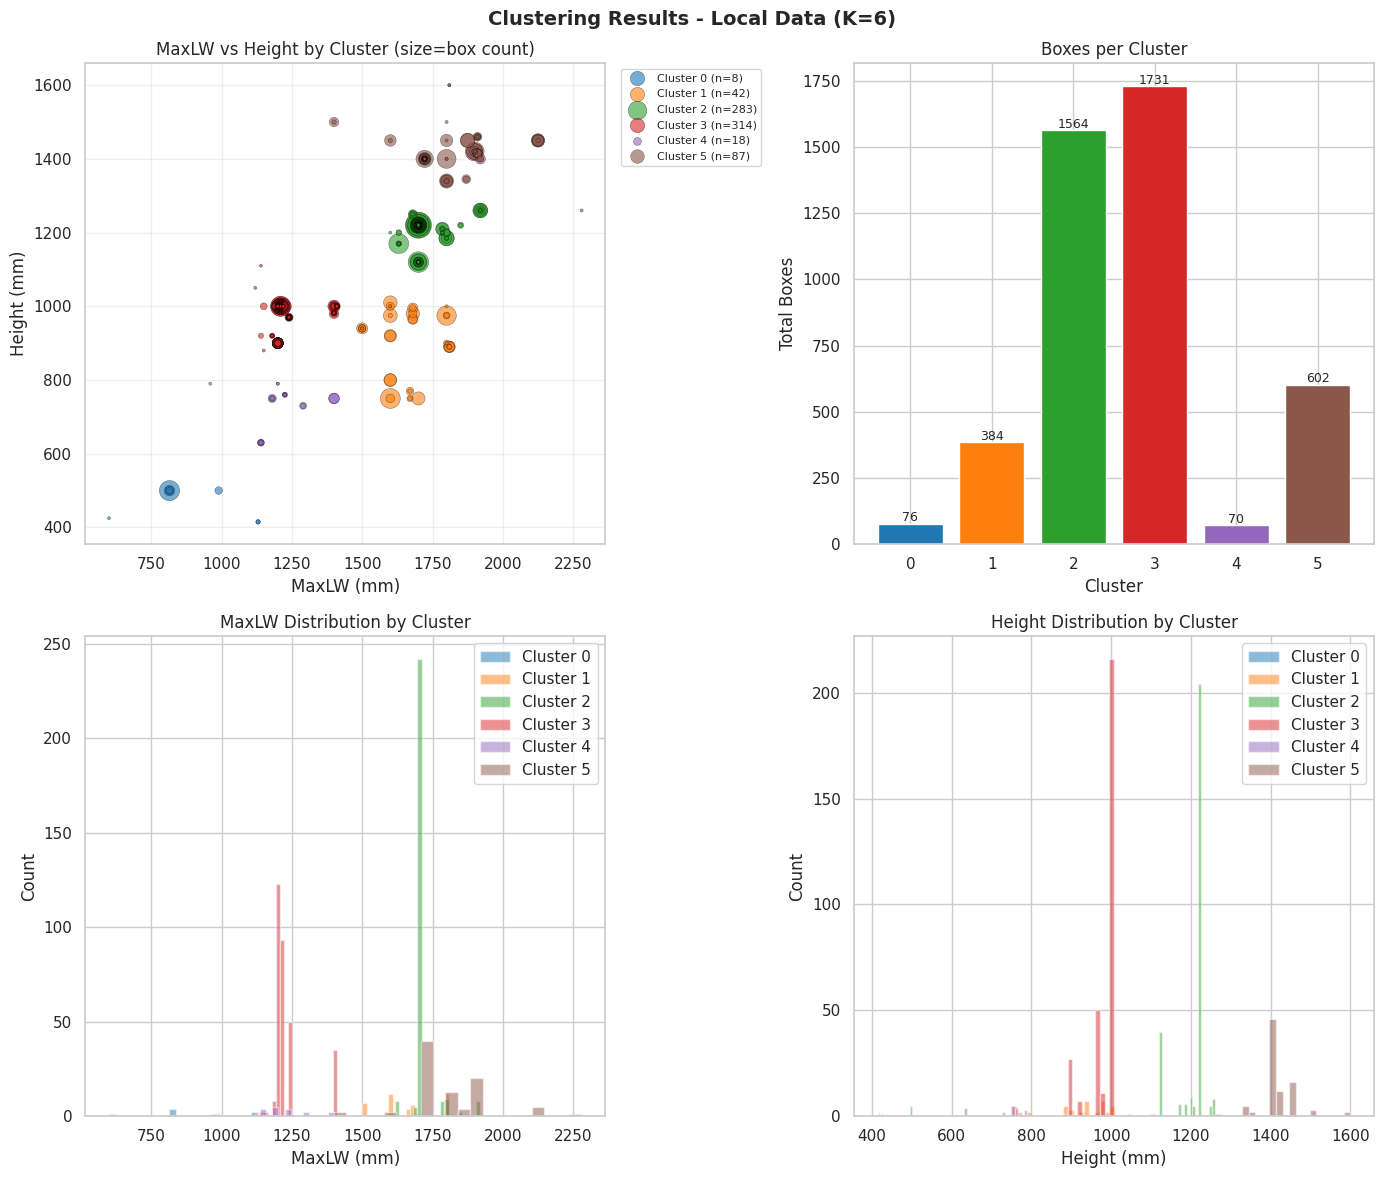

Chart saved: local_clusters.png

Merged Specifications for Packing
{'='*60}
Cluster 0: Std_MaxLW=1130, Std_Height=500 (8 types, 76 boxes)
Cluster 1: Std_MaxLW=1810, Std_Height=1010 (42 types, 384 boxes)
Cluster 2: Std_MaxLW=1920, Std_Height=1260 (283 types, 1564 boxes)
Cluster 3: Std_MaxLW=1410, Std_Height=1110 (314 types, 1731 boxes)
Cluster 4: Std_MaxLW=1400, Std_Height=790 (18 types, 70 boxes)
Cluster 5: Std_MaxLW=2280, Std_Height=1600 (87 types, 602 boxes)

Saved: local_clustered.xlsx
Saved: local_merged_specs.xlsx


In [9]:
df_result, stats, merged_specs = full_cluster_analysis(
    df_local,
    k_range=range(2, 21),
    title="Local Data",
    save_prefix="local"
)

# 环境


In [10]:
"""
Glass Shelf Packing Optimization - New Warehouse
- Shelf height: 7800mm
- Shelf span width: 3600mm or 2700mm (two options)
- Shelf depth: 1100mm
- Target: Minimize total floor area, max 4 config types
"""

import numpy as np
import pandas as pd
from collections import Counter, defaultdict

# ============================================
# Parameters
# ============================================
SHELF_H = 7800.0         # Shelf height (mm)
SHELF_W_OPTIONS = [3600.0, 2700.0]  # Shelf span width options (mm)
SHELF_DEPTH = 1100.0     # Shelf depth (mm)
SEP = 27.0               # Separator thickness (mm)
GAP = 9.0                # Gap between glass (mm)
MAX_STACK1 = 4           # Max stack on first layer
MAX_STACK2 = 2           # Max stack on other layers
W_STEP = 10              # Width merge step (mm)


def load_and_merge(df, w_step=W_STEP):
    """
    Load data and merge width
    Expected columns: MaxLW, Height, Count, GlassID/PartNo
    """
    print(f"{'='*60}")
    print("Loading and Merging Data")
    print(f"{'='*60}")

    # Detect columns
    maxlw_col = next((c for c in df.columns if 'MaxLW' in c or 'maxlw' in c.lower()), None)
    h_col = next((c for c in df.columns if c == 'Height' or c == '高'), None)
    cnt_col = next((c for c in df.columns if c == 'Count' or c == '数量'), None)
    id_col = next((c for c in df.columns if 'GlassID' in c or 'PartNo' in c or 'ID' in c), None)

    print(f"Detected columns: MaxLW={maxlw_col}, Height={h_col}, Count={cnt_col}, ID={id_col}")

    if not all([maxlw_col, h_col, cnt_col]):
        raise ValueError(f"Missing required columns. Found: {df.columns.tolist()}")

    df = df.copy()
    df['orig_w'] = df[maxlw_col].astype(float)  # Use MaxLW as width
    df['orig_h'] = df[h_col].astype(float)
    df['count'] = df[cnt_col].astype(int)
    df['glass_id'] = df[id_col] if id_col else range(len(df))

    # Merge width only
    df['std_w'] = np.ceil(df['orig_w'] / w_step) * w_step
    df['std_h'] = df['orig_h']

    n_orig = len(df)
    n_merged = len(df.groupby(['std_w', 'std_h']))

    print(f"\nGlass specs: {n_orig} -> {n_merged} (width step {w_step}mm)")
    print(f"Total boxes: {df['count'].sum()}")
    print(f"MaxLW range: {df['orig_w'].min():.0f} - {df['orig_w'].max():.0f} mm")
    print(f"Height range: {df['orig_h'].min():.0f} - {df['orig_h'].max():.0f} mm")

    return df


def pack_single_width(df, shelf_w, min_layers=2, min_layer_h=100):
    """
    Pack glass into shelves with specified width
    """
    print(f"\n{'='*60}")
    print(f"Packing with Shelf Width = {shelf_w}mm")
    print(f"Shelf dimensions: {shelf_w} x {SHELF_H} x {SHELF_DEPTH} mm")
    print(f"{'='*60}")

    # Expand glass list
    glasses = []
    for _, row in df.iterrows():
        for _ in range(row['count']):
            glasses.append({
                'id': row['glass_id'],
                'std_w': row['std_w'],
                'std_h': row['std_h'],
                'orig_w': row['orig_w'],
                'orig_h': row['orig_h']
            })

    # Sort by area descending
    glasses.sort(key=lambda g: -g['std_w'] * g['std_h'])

    shelves = []

    for g in glasses:
        gw, gh, gid = g['std_w'], g['std_h'], g['id']
        placed = False

        # Check if glass fits in shelf width
        if gw > shelf_w:
            print(f"Warning: Glass {gid} width {gw}mm > shelf width {shelf_w}mm, skipped")
            continue

        for shelf in shelves:
            # 1. Try stacking
            for li, layer in enumerate(shelf['layers']):
                for pos in layer['positions']:
                    if pos['id'] == gid:
                        max_stack = MAX_STACK1 if li == 0 else MAX_STACK2
                        if pos['stack'] < max_stack:
                            new_h = gh * (pos['stack'] + 1)
                            new_layer_h = max(layer['height'], new_h)

                            test_total = sum(l['height'] for l in shelf['layers']) + (len(shelf['layers'])-1)*SEP
                            test_total += new_layer_h - layer['height']

                            if test_total <= SHELF_H:
                                pos['stack'] += 1
                                layer['height'] = new_layer_h
                                placed = True
                                break
                if placed:
                    break
            if placed:
                break

            # 2. New position in existing layer
            for li, layer in enumerate(shelf['layers']):
                if gh > layer['height']:
                    continue
                used_w = sum(p['w'] for p in layer['positions'])
                if layer['positions']:
                    used_w += GAP * len(layer['positions'])
                if used_w + gw <= shelf_w:
                    layer['positions'].append({
                        'id': gid, 'w': gw, 'h': gh,
                        'orig_w': g['orig_w'], 'orig_h': g['orig_h'], 'stack': 1
                    })
                    placed = True
                    break
            if placed:
                break

            # 3. New layer
            n_layers = len(shelf['layers'])
            total_h = sum(l['height'] for l in shelf['layers']) + n_layers * SEP
            remaining = SHELF_H - total_h

            if gh <= remaining and remaining >= gh:
                shelf['layers'].append({
                    'height': gh,
                    'positions': [{'id': gid, 'w': gw, 'h': gh,
                                   'orig_w': g['orig_w'], 'orig_h': g['orig_h'], 'stack': 1}]
                })
                placed = True
                break

        # 4. New shelf
        if not placed:
            shelves.append({
                'width': shelf_w,
                'layers': [{
                    'height': gh,
                    'positions': [{'id': gid, 'w': gw, 'h': gh,
                                   'orig_w': g['orig_w'], 'orig_h': g['orig_h'], 'stack': 1}]
                }]
            })

    total_boxes = sum(
        pos['stack']
        for s in shelves
        for l in s['layers']
        for pos in l['positions']
    )

    # Calculate floor area
    total_area_mm2 = len(shelves) * shelf_w * SHELF_DEPTH
    total_area_m2 = total_area_mm2 / 1_000_000  # Convert to m²

    print(f"\nResults:")
    print(f"  Shelves: {len(shelves)}")
    print(f"  Boxes: {total_boxes}")
    print(f"  Floor area: {total_area_m2:.2f} m²")

    return shelves, total_area_m2


def pack_mixed_width(df, min_layers=2):
    """
    Pack glass using mixed shelf widths (3600 and 2700)
    Strategy: Try to use narrower shelves when possible
    """
    print(f"\n{'='*60}")
    print("Packing with Mixed Shelf Widths")
    print(f"Options: {SHELF_W_OPTIONS}mm")
    print(f"{'='*60}")

    # Expand and sort glass list
    glasses = []
    for _, row in df.iterrows():
        for _ in range(row['count']):
            glasses.append({
                'id': row['glass_id'],
                'std_w': row['std_w'],
                'std_h': row['std_h'],
                'orig_w': row['orig_w'],
                'orig_h': row['orig_h']
            })

    glasses.sort(key=lambda g: -g['std_w'] * g['std_h'])

    shelves = []

    for g in glasses:
        gw, gh, gid = g['std_w'], g['std_h'], g['id']
        placed = False

        # Determine minimum required shelf width
        min_shelf_w = min(w for w in SHELF_W_OPTIONS if w >= gw) if any(w >= gw for w in SHELF_W_OPTIONS) else None

        if min_shelf_w is None:
            print(f"Warning: Glass {gid} width {gw}mm > max shelf width, skipped")
            continue

        # Try existing shelves (prefer same width, then larger)
        for shelf in sorted(shelves, key=lambda s: (s['width'] != min_shelf_w, -s['width'])):
            if shelf['width'] < gw:
                continue

            # 1. Try stacking
            for li, layer in enumerate(shelf['layers']):
                for pos in layer['positions']:
                    if pos['id'] == gid:
                        max_stack = MAX_STACK1 if li == 0 else MAX_STACK2
                        if pos['stack'] < max_stack:
                            new_h = gh * (pos['stack'] + 1)
                            new_layer_h = max(layer['height'], new_h)

                            test_total = sum(l['height'] for l in shelf['layers']) + (len(shelf['layers'])-1)*SEP
                            test_total += new_layer_h - layer['height']

                            if test_total <= SHELF_H:
                                pos['stack'] += 1
                                layer['height'] = new_layer_h
                                placed = True
                                break
                if placed:
                    break
            if placed:
                break

            # 2. New position in existing layer
            for li, layer in enumerate(shelf['layers']):
                if gh > layer['height']:
                    continue
                used_w = sum(p['w'] for p in layer['positions'])
                if layer['positions']:
                    used_w += GAP * len(layer['positions'])
                if used_w + gw <= shelf['width']:
                    layer['positions'].append({
                        'id': gid, 'w': gw, 'h': gh,
                        'orig_w': g['orig_w'], 'orig_h': g['orig_h'], 'stack': 1
                    })
                    placed = True
                    break
            if placed:
                break

            # 3. New layer
            n_layers = len(shelf['layers'])
            total_h = sum(l['height'] for l in shelf['layers']) + n_layers * SEP
            remaining = SHELF_H - total_h

            if gh <= remaining:
                shelf['layers'].append({
                    'height': gh,
                    'positions': [{'id': gid, 'w': gw, 'h': gh,
                                   'orig_w': g['orig_w'], 'orig_h': g['orig_h'], 'stack': 1}]
                })
                placed = True
                break

        # 4. New shelf (use minimum required width)
        if not placed:
            shelves.append({
                'width': min_shelf_w,
                'layers': [{
                    'height': gh,
                    'positions': [{'id': gid, 'w': gw, 'h': gh,
                                   'orig_w': g['orig_w'], 'orig_h': g['orig_h'], 'stack': 1}]
                }]
            })

    # Statistics
    total_boxes = sum(
        pos['stack']
        for s in shelves
        for l in s['layers']
        for pos in l['positions']
    )

    width_counts = Counter(s['width'] for s in shelves)
    total_area_mm2 = sum(s['width'] * SHELF_DEPTH for s in shelves)
    total_area_m2 = total_area_mm2 / 1_000_000

    print(f"\nResults:")
    print(f"  Total shelves: {len(shelves)}")
    for w, cnt in sorted(width_counts.items()):
        print(f"    Width {w}mm: {cnt} shelves")
    print(f"  Total boxes: {total_boxes}")
    print(f"  Floor area: {total_area_m2:.2f} m²")

    return shelves, total_area_m2


def get_config(shelf):
    """Get shelf configuration (layer heights)"""
    heights = tuple(sorted([l['height'] for l in shelf['layers']], reverse=True))
    return (shelf['width'], heights)


def merge_configs(shelves, target_types=4):
    """
    Merge shelf configurations to target number of types
    """
    print(f"\n{'='*60}")
    print(f"Merging Configurations (target: {target_types} types)")
    print(f"{'='*60}")

    # Get current configs
    config_map = {i: get_config(s) for i, s in enumerate(shelves)}
    config_counts = Counter(config_map.values())

    print(f"Initial config types: {len(config_counts)}")

    iteration = 0
    while len(config_counts) > target_types:
        iteration += 1

        best_merge = None
        best_score = float('inf')

        configs = list(config_counts.keys())
        for i, cfg1 in enumerate(configs):
            for cfg2 in configs[i+1:]:
                w1, h1 = cfg1
                w2, h2 = cfg2

                # Same width and layer count
                if w1 != w2 or len(h1) != len(h2):
                    continue

                # Merge: max of each layer
                merged_h = tuple(max(a, b) for a, b in zip(h1, h2))
                total_h = sum(merged_h) + (len(merged_h) - 1) * SEP

                if total_h > SHELF_H:
                    continue

                expand = sum(merged_h) - sum(h1) + sum(merged_h) - sum(h2)
                n_shelves = config_counts[cfg1] + config_counts[cfg2]
                score = expand / n_shelves if n_shelves > 0 else float('inf')

                if score < best_score:
                    best_score = score
                    best_merge = (cfg1, cfg2, (w1, merged_h))

        if best_merge is None:
            print(f"Cannot merge further, stopped at {len(config_counts)} types")
            break

        cfg1, cfg2, merged = best_merge
        new_count = config_counts[cfg1] + config_counts[cfg2]
        del config_counts[cfg1]
        del config_counts[cfg2]

        if merged in config_counts:
            config_counts[merged] += new_count
        else:
            config_counts[merged] = new_count

        for idx, cfg in config_map.items():
            if cfg == cfg1 or cfg == cfg2:
                config_map[idx] = merged

        if len(config_counts) <= 10 or iteration % 20 == 0:
            print(f"  Iteration {iteration}: {len(config_counts)} types")

    print(f"\nFinal config types: {len(config_counts)}")
    for cfg, cnt in sorted(config_counts.items(), key=lambda x: -x[1]):
        w, h = cfg
        h_str = "+".join([f"{x:.0f}" for x in h])
        total_h = sum(h) + (len(h) - 1) * SEP
        print(f"  W={w:.0f}, [{h_str}] (H={total_h:.0f}): {cnt} shelves")

    return config_counts, config_map


def repack_small_batches(shelves, config_counts, config_map, threshold=10):
    """
    Repack small batch shelves using standard configurations
    """
    print(f"\n{'='*60}")
    print(f"Repacking Small Batches (threshold < {threshold})")
    print(f"{'='*60}")

    standard_cfgs = {cfg for cfg, cnt in config_counts.items() if cnt >= threshold}
    small_cfgs = {cfg for cfg, cnt in config_counts.items() if cnt < threshold}

    print(f"Standard configs: {len(standard_cfgs)}")
    print(f"Small batch configs: {len(small_cfgs)}")

    if not small_cfgs:
        print("No small batches, skipping repack")
        return shelves, config_counts

    # Separate shelves
    standard_shelves = []
    extracted_glass = []

    for idx, shelf in enumerate(shelves):
        cfg = config_map[idx]
        if cfg in small_cfgs:
            for layer in shelf['layers']:
                for pos in layer['positions']:
                    for _ in range(pos['stack']):
                        extracted_glass.append({
                            'id': pos['id'], 'std_w': pos['w'], 'std_h': pos['h'],
                            'orig_w': pos['orig_w'], 'orig_h': pos['orig_h']
                        })
        else:
            standard_shelves.append(shelf)

    print(f"Kept shelves: {len(standard_shelves)}")
    print(f"Extracted glass: {len(extracted_glass)} boxes")

    if not extracted_glass:
        return shelves, config_counts

    # Repack using standard configs
    configs = sorted(list(standard_cfgs), key=lambda c: (-c[0], -sum(c[1])))
    new_shelves = []

    glass_by_id = defaultdict(list)
    for g in extracted_glass:
        glass_by_id[g['id']].append(g)

    glass_ids = sorted(glass_by_id.keys(), key=lambda gid: -glass_by_id[gid][0]['std_h'])
    remaining = {gid: len(gs) for gid, gs in glass_by_id.items()}
    glass_info = {gid: gs[0] for gid, gs in glass_by_id.items()}

    for gid in glass_ids:
        g = glass_info[gid]
        gw, gh = g['std_w'], g['std_h']

        while remaining[gid] > 0:
            placed = False

            for shelf in new_shelves:
                cfg_w, cfg_h = shelf['config']

                if gw > cfg_w:
                    continue

                # Try stacking
                for li, layer in enumerate(shelf['layers']):
                    for pos in layer:
                        if pos['id'] == gid:
                            max_stack = MAX_STACK1 if li == 0 else MAX_STACK2
                            if pos['stack'] < max_stack and gh * (pos['stack'] + 1) <= cfg_h[li]:
                                pos['stack'] += 1
                                remaining[gid] -= 1
                                placed = True
                                break
                    if placed:
                        break
                if placed:
                    break

                # New position
                for li, layer in enumerate(shelf['layers']):
                    if gh > cfg_h[li]:
                        continue
                    used_w = sum(glass_info[p['id']]['std_w'] for p in layer)
                    if layer:
                        used_w += GAP * len(layer)
                    if used_w + gw <= cfg_w:
                        layer.append({
                            'id': gid, 'w': gw, 'h': gh,
                            'orig_w': g['orig_w'], 'orig_h': g['orig_h'], 'stack': 1
                        })
                        remaining[gid] -= 1
                        placed = True
                        break
                if placed:
                    break

            # New shelf
            if not placed:
                best_cfg = None
                best_waste = float('inf')
                for cfg in configs:
                    cfg_w, cfg_h = cfg
                    if gw > cfg_w:
                        continue
                    for layer_h in cfg_h:
                        if layer_h >= gh:
                            waste = layer_h - gh
                            if waste < best_waste:
                                best_waste = waste
                                best_cfg = cfg
                            break

                if best_cfg is None:
                    print(f"Warning: Cannot place glass {gid}")
                    break

                cfg_w, cfg_h = best_cfg
                best_layer = min(range(len(cfg_h)),
                               key=lambda i: cfg_h[i] - gh if cfg_h[i] >= gh else float('inf'))

                new_shelf = {'config': best_cfg, 'width': cfg_w, 'layers': [[] for _ in cfg_h]}
                new_shelf['layers'][best_layer].append({
                    'id': gid, 'w': gw, 'h': gh,
                    'orig_w': g['orig_w'], 'orig_h': g['orig_h'], 'stack': 1
                })
                new_shelves.append(new_shelf)
                remaining[gid] -= 1

    print(f"New shelves: {len(new_shelves)}")

    # Final statistics
    final_config_counts = Counter()
    for shelf in standard_shelves:
        final_config_counts[get_config(shelf)] += 1
    for shelf in new_shelves:
        final_config_counts[shelf['config']] += 1

    total_shelves = len(standard_shelves) + len(new_shelves)

    # Calculate area
    area_mm2 = sum(s['width'] * SHELF_DEPTH for s in standard_shelves)
    area_mm2 += sum(s['width'] * SHELF_DEPTH for s in new_shelves)
    area_m2 = area_mm2 / 1_000_000

    print(f"\nFinal: {total_shelves} shelves, {len(final_config_counts)} config types")
    print(f"Floor area: {area_m2:.2f} m²")

    return (standard_shelves, new_shelves), final_config_counts


def calculate_area(shelves_data, config_counts):
    """
    Calculate total floor area in m²
    """
    if isinstance(shelves_data, tuple):
        standard_shelves, new_shelves = shelves_data
        area_mm2 = sum(s['width'] * SHELF_DEPTH for s in standard_shelves)
        area_mm2 += sum(s['width'] * SHELF_DEPTH for s in new_shelves)
        total_shelves = len(standard_shelves) + len(new_shelves)
    else:
        area_mm2 = sum(s['width'] * SHELF_DEPTH for s in shelves_data)
        total_shelves = len(shelves_data)

    area_m2 = area_mm2 / 1_000_000

    print(f"\n{'='*60}")
    print("Area Summary")
    print(f"{'='*60}")
    print(f"Total shelves: {total_shelves}")
    print(f"Config types: {len(config_counts)}")
    print(f"Floor area: {area_m2:.2f} m²")

    # Breakdown by width
    width_counts = Counter()
    if isinstance(shelves_data, tuple):
        for s in standard_shelves:
            width_counts[s['width']] += 1
        for s in new_shelves:
            width_counts[s['width']] += 1
    else:
        for s in shelves_data:
            width_counts[s['width']] += 1

    for w, cnt in sorted(width_counts.items()):
        w_area = cnt * w * SHELF_DEPTH / 1_000_000
        print(f"  Width {w:.0f}mm: {cnt} shelves, {w_area:.2f} m²")

    return area_m2


def optimize(df, target_configs=4, small_threshold=10, w_step=10, use_mixed_width=True):
    """
    Full optimization workflow

    Args:
        df: DataFrame with MaxLW, Height, Count columns
        target_configs: Target number of config types (default 4)
        small_threshold: Small batch threshold
        w_step: Width merge step
        use_mixed_width: Use both 3600 and 2700 widths
    """
    print("="*60)
    print("Glass Shelf Packing Optimization")
    print("="*60)
    print(f"Target: {target_configs} config types")
    print(f"Shelf height: {SHELF_H}mm ({SHELF_H/1000:.1f}m)")
    print(f"Shelf depth: {SHELF_DEPTH}mm")
    print(f"Shelf widths: {SHELF_W_OPTIONS}mm")
    print("="*60)

    # Step 1: Load and merge
    df_merged = load_and_merge(df, w_step=w_step)

    # Step 2: Initial packing
    if use_mixed_width:
        shelves, area = pack_mixed_width(df_merged)
    else:
        shelves, area = pack_single_width(df_merged, SHELF_W_OPTIONS[0])

    # Step 3: Merge configs
    config_counts, config_map = merge_configs(shelves, target_types=target_configs)

    # Step 4: Repack small batches
    while len(config_counts) > target_configs:
        print(f"\nConfigs ({len(config_counts)}) > target ({target_configs}), continue merging...")
        config_counts, config_map = merge_configs(shelves, target_types=target_configs)

        if len(config_counts) <= target_configs:
            break

        small_threshold = min(small_threshold + 5, 50)
        shelves_data, config_counts = repack_small_batches(
            shelves, config_counts, config_map, threshold=small_threshold
        )

    shelves_data, config_counts = repack_small_batches(
        shelves, config_counts, config_map, threshold=small_threshold
    )

    # Final area calculation
    final_area = calculate_area(shelves_data, config_counts)

    print("\n" + "="*60)
    print("OPTIMIZATION COMPLETE")
    print("="*60)
    print(f"Config types: {len(config_counts)}")
    print(f"Total floor area: {final_area:.2f} m²")

    for cfg, cnt in sorted(config_counts.items(), key=lambda x: -x[1]):
        w, h = cfg
        h_str = "+".join([f"{x:.0f}" for x in h])
        total_h = sum(h) + (len(h) - 1) * SEP
        cfg_area = cnt * w * SHELF_DEPTH / 1_000_000
        print(f"  W={w:.0f}, [{h_str}] (H={total_h:.0f}): {cnt} shelves, {cfg_area:.2f} m²")

    return shelves_data, config_counts, final_area


def compare_strategies(df):
    """
    Compare different packing strategies
    """
    print("\n" + "="*70)
    print("STRATEGY COMPARISON")
    print("="*70)

    results = {}

    # Strategy 1: 3600mm only
    print("\n>>> Strategy 1: 3600mm width only")
    df_merged = load_and_merge(df.copy())
    s1, a1 = pack_single_width(df_merged, 3600)
    results['3600_only'] = {'shelves': len(s1), 'area': a1}

    # Strategy 2: 2700mm only
    print("\n>>> Strategy 2: 2700mm width only")
    df_merged = load_and_merge(df.copy())
    s2, a2 = pack_single_width(df_merged, 2700)
    results['2700_only'] = {'shelves': len(s2), 'area': a2}

    # Strategy 3: Mixed width
    print("\n>>> Strategy 3: Mixed widths (3600 + 2700)")
    df_merged = load_and_merge(df.copy())
    s3, a3 = pack_mixed_width(df_merged)
    results['mixed'] = {'shelves': len(s3), 'area': a3}

    # Summary
    print("\n" + "="*70)
    print("COMPARISON SUMMARY")
    print("="*70)
    print(f"{'Strategy':<20} {'Shelves':>10} {'Area (m²)':>12}")
    print("-"*45)
    for name, data in results.items():
        print(f"{name:<20} {data['shelves']:>10} {data['area']:>12.2f}")

    best = min(results.items(), key=lambda x: x[1]['area'])
    print(f"\nBest strategy: {best[0]} (area = {best[1]['area']:.2f} m²)")

    return results

# 选择跨宽

In [11]:
df = df_local
results = compare_strategies(df)


STRATEGY COMPARISON

>>> Strategy 1: 3600mm width only
Loading and Merging Data
Detected columns: MaxLW=MaxLW, Height=Height, Count=Count, ID=GlassID

Glass specs: 752 -> 72 (width step 10mm)
Total boxes: 4427
MaxLW range: 600 - 2280 mm
Height range: 415 - 1600 mm

Packing with Shelf Width = 3600mm
Shelf dimensions: 3600 x 7800.0 x 1100.0 mm

Results:
  Shelves: 365
  Boxes: 4427
  Floor area: 1445.40 m²

>>> Strategy 2: 2700mm width only
Loading and Merging Data
Detected columns: MaxLW=MaxLW, Height=Height, Count=Count, ID=GlassID

Glass specs: 752 -> 72 (width step 10mm)
Total boxes: 4427
MaxLW range: 600 - 2280 mm
Height range: 415 - 1600 mm

Packing with Shelf Width = 2700mm
Shelf dimensions: 2700 x 7800.0 x 1100.0 mm

Results:
  Shelves: 553
  Boxes: 4427
  Floor area: 1642.41 m²

>>> Strategy 3: Mixed widths (3600 + 2700)
Loading and Merging Data
Detected columns: MaxLW=MaxLW, Height=Height, Count=Count, ID=GlassID

Glass specs: 752 -> 72 (width step 10mm)
Total boxes: 4427
MaxL

In [ ]:
compare_strategies(df)
df_merged = merge_width_only(df, w_step=10)

合并策略对比

策略                   规格数       高度膨胀       宽度膨胀
--------------------------------------------------
高5+宽20                53     101.7%     106.1%
高3+宽20                59     101.2%     106.1%
高5+宽15                60     101.7%     104.9%
高3+宽15                65     101.2%     104.9%
高5+宽10                65     101.7%     101.7%
宽度30mm                67     100.0%     107.9%
宽度25mm                70     100.0%     104.9%
宽度20mm                73     100.0%     106.1%
高3+宽10                74     101.2%     101.7%
宽度15mm                77     100.0%     104.9%
宽度10mm                81     100.0%     101.7%
宽度5mm                 85     100.0%     100.6%
只合并宽度 (步长=10mm)
原始规格: 93种
合并后: 81种
减少: 12种 (12.9%)
宽度膨胀: 平均101.7%


In [ ]:
"""
玻璃货架装箱 V11c
修复：层高动态调整（与V9一致）
"""

import numpy as np
import pandas as pd
import time
from collections import Counter, defaultdict


# 常量 (mm)
SHELF_W = 360.0
SHELF_H = 800.0
SEP = 27.0
GAP = 9.0
MAX_STACK1 = 4
MAX_STACK2 = 2


class Packer:
    def __init__(self, df, use_standard=True, min_layers=3, min_layer_h=50):
        # 检测列名
        if use_standard and '标准高' in df.columns and '标准宽' in df.columns:
            print("使用标准规格进行装箱")
            h_col = '标准高'
            w_col = '标准宽'
            orig_h_col = next((c for c in ['高2', 'height'] if c in df.columns), None)
            orig_w_col = next((c for c in ['最短宽', 'width'] if c in df.columns), None)
        else:
            print("使用原始规格进行装箱")
            h_col = next((c for c in ['高2', 'height'] if c in df.columns), None)
            w_col = next((c for c in ['最短宽', 'width'] if c in df.columns), None)
            orig_h_col = h_col
            orig_w_col = w_col

        id_col = next((c for c in ['玻璃索引', 'glass_id', 'id'] if c in df.columns), None)
        cnt_col = next((c for c in ['Count of 玻璃索引', 'count', '数量'] if c in df.columns), None)

        self.df = df.copy()
        self.ids = df[id_col].values.astype(int) if id_col else np.arange(len(df))
        self.W = df[w_col].values.astype(float)
        self.H = df[h_col].values.astype(float)
        self.C = df[cnt_col].values.astype(int)

        self.orig_H = df[orig_h_col].values.astype(float) if orig_h_col else self.H
        self.orig_W = df[orig_w_col].values.astype(float) if orig_w_col else self.W

        # 标准规格映射
        self.spec_to_indices = defaultdict(list)
        for i in range(len(self.W)):
            spec = (self.H[i], self.W[i])
            self.spec_to_indices[spec].append(i)

        self.min_layers = min_layers
        self.min_layer_h = min_layer_h

        self.n = len(self.W)
        self.total_boxes = self.C.sum()
        unique_specs = len(self.spec_to_indices)

        print(f"玻璃种类: {self.n} | 标准规格: {unique_specs} | 总箱数: {self.total_boxes}")

        self.best_order = None
        self.best_result = None

    def get_spec(self, idx):
        return (self.H[idx], self.W[idx])

    def _calc_shelf_height(self, layers):
        """计算货架当前高度"""
        if not layers:
            return 0
        total = sum(l['height'] for l in layers)
        total += (len(layers) - 1) * SEP
        return total

    def _get_min_remaining(self, n_layers):
        """计算还需要的最小高度（满足最小层数约束）"""
        if n_layers >= self.min_layers:
            return 0
        need = self.min_layers - n_layers
        return need * self.min_layer_h + need * SEP

    def _can_fit(self, layers, delta=0):
        """检查是否还能放（考虑最小层数约束）"""
        current_h = self._calc_shelf_height(layers) + delta
        min_remaining = self._get_min_remaining(len(layers))
        return current_h + min_remaining <= SHELF_H

    def pack(self, order):
        """
        贪心装箱 - 动态层高版本
        """
        remaining = self.C.copy()
        shelves = []

        for idx in order:
            gw, gh = self.W[idx], self.H[idx]
            spec = self.get_spec(idx)

            while remaining[idx] > 0:
                placed = False

                for shelf in shelves:
                    layers = shelf['layers']

                    # 1. 尝试叠放（只有同玻璃索引才能叠放）
                    for li, layer in enumerate(layers):
                        for pos in layer['positions']:
                            # 只有同一玻璃索引才能叠放
                            if pos['glass_idx'] == idx:
                                max_stack = MAX_STACK1 if li == 0 else MAX_STACK2
                                if pos['stack'] < max_stack:
                                    # 叠放高度 = 玻璃高 × (叠放数+1)
                                    new_stack_h = gh * (pos['stack'] + 1)
                                    new_layer_h = max(layer['height'], new_stack_h)
                                    delta = new_layer_h - layer['height']

                                    # 检查是否能放（考虑层高增加）
                                    if self._can_fit(layers, delta):
                                        pos['stack'] += 1
                                        pos['stack_height'] = new_stack_h
                                        layer['height'] = new_layer_h
                                        remaining[idx] -= 1
                                        placed = True
                                        break
                        if placed:
                            break
                    if placed:
                        break

                    # 2. 现有层新位置
                    for li, layer in enumerate(layers):
                        used_w = sum(self.W[p['glass_idx']] for p in layer['positions'])
                        if layer['positions']:
                            used_w += GAP * len(layer['positions'])

                        if used_w + gw <= SHELF_W:
                            new_layer_h = max(layer['height'], gh)
                            delta = new_layer_h - layer['height']

                            if self._can_fit(layers, delta):
                                layer['positions'].append({
                                    'glass_idx': idx,
                                    'stack': 1,
                                    'stack_height': gh
                                })
                                layer['height'] = new_layer_h
                                remaining[idx] -= 1
                                placed = True
                                break
                    if placed:
                        break

                    # 3. 新层
                    if self._can_fit(layers, gh + SEP):
                        layers.append({
                            'height': gh,
                            'positions': [{
                                'glass_idx': idx,
                                'stack': 1,
                                'stack_height': gh
                            }]
                        })
                        remaining[idx] -= 1
                        placed = True
                        break

                # 4. 新货架
                if not placed:
                    shelves.append({
                        'layers': [{
                            'height': gh,
                            'positions': [{
                                'glass_idx': idx,
                                'stack': 1,
                                'stack_height': gh
                            }]
                        }]
                    })
                    remaining[idx] -= 1

        # 填充空层
        for shelf in shelves:
            layers = shelf['layers']
            while len(layers) < self.min_layers:
                current_h = self._calc_shelf_height(layers)
                remain_h = SHELF_H - current_h - SEP
                if remain_h >= self.min_layer_h:
                    layers.append({
                        'height': self.min_layer_h,
                        'positions': []
                    })
                else:
                    break

        return len(shelves), shelves

    def pack_count_only(self, order):
        n, _ = self.pack(order)
        return n

    def get_orders(self):
        orders = {}
        orders['area_desc'] = np.argsort(-(self.W * self.H))
        orders['height_desc'] = np.argsort(-self.H)
        orders['width_desc'] = np.argsort(-self.W)
        orders['count_desc'] = np.argsort(-self.C)
        orders['volume_desc'] = np.argsort(-(self.W * self.H * self.C))
        orders['h_w_desc'] = np.lexsort((-self.W, -self.H))

        # 按标准规格分组
        spec_order = []
        for spec in sorted(self.spec_to_indices.keys(), key=lambda s: -s[0]*s[1]):
            indices = self.spec_to_indices[spec]
            indices_sorted = sorted(indices, key=lambda i: -self.C[i])
            spec_order.extend(indices_sorted)
        orders['spec_group'] = np.array(spec_order)

        return orders

    def local_search(self, order, max_iter=5000, max_time=60):
        n = len(order)
        current = list(order)
        current_cost = self.pack_count_only(current)
        best, best_cost = current.copy(), current_cost

        start = time.time()
        no_improve, temp = 0, 2.0

        for it in range(max_iter):
            if time.time() - start > max_time or no_improve > 800:
                break

            new = current.copy()
            r = np.random.random()
            if r < 0.5:
                i, j = np.random.randint(0, n, 2)
                new[i], new[j] = new[j], new[i]
            elif r < 0.8:
                i, j = np.random.randint(0, n), np.random.randint(0, n)
                v = new.pop(i)
                new.insert(j, v)
            else:
                i, j = sorted(np.random.randint(0, n, 2))
                new[i:j+1] = new[i:j+1][::-1]

            new_cost = self.pack_count_only(new)
            delta = new_cost - current_cost

            if delta < 0 or (temp > 0.01 and np.random.random() < np.exp(-delta / temp)):
                current, current_cost = new, new_cost
                if current_cost < best_cost:
                    best, best_cost = current.copy(), current_cost
                    no_improve = 0
                else:
                    no_improve += 1
            else:
                no_improve += 1

            temp *= 0.997

        return best, best_cost

    def statistics(self, shelves):
        total_layers = sum(len(s['layers']) for s in shelves)
        empty_layers = sum(1 for s in shelves for l in s['layers'] if not l['positions'])
        total_boxes = sum(pos['stack'] for s in shelves for l in s['layers'] for pos in l['positions'])

        stack_counts = Counter(pos['stack'] for s in shelves for l in s['layers'] for pos in l['positions'])
        layer_counts = Counter(len(s['layers']) for s in shelves)

        print("\n" + "=" * 60)
        print("货架统计")
        print("=" * 60)
        print(f"总货架数: {len(shelves)}")
        print(f"总箱数: {total_boxes}")
        print(f"总层数: {total_layers} | 空层: {empty_layers}")

        print("\n叠放统计:")
        for stk in sorted(stack_counts.keys()):
            print(f"  叠放{stk}个: {stack_counts[stk]}处")

        print("\n按层数分类:")
        for n_layers in sorted(layer_counts.keys()):
            cnt = layer_counts[n_layers]
            print(f"  {n_layers}层货架: {cnt}个 ({cnt/len(shelves)*100:.1f}%)")

        return layer_counts

    def export(self, shelves, filename="装箱方案_V11c.xlsx"):
        rows = []

        for si, shelf in enumerate(shelves):
            layers = shelf['layers']
            shelf_h = self._calc_shelf_height(layers)
            shelf_boxes = sum(pos['stack'] for l in layers for pos in l['positions'])

            for li, layer in enumerate(layers):
                layer_h = layer['height']
                layer_boxes = sum(pos['stack'] for pos in layer['positions'])
                layer_w = sum(self.W[pos['glass_idx']] for pos in layer['positions'])
                if layer['positions']:
                    layer_w += GAP * (len(layer['positions']) - 1)

                if not layer['positions']:
                    rows.append({
                        '货架号': si + 1, '货架层数': len(layers),
                        '货架总高mm': round(shelf_h, 1), '货架箱数': shelf_boxes,
                        '层号': li + 1, '层高mm': round(layer_h, 1),
                        '层已用宽mm': 0, '层箱数': 0,
                        '位置号': '-', '玻璃ID': '(空层)',
                        '标准宽mm': '-', '标准高mm': '-',
                        '原始宽mm': '-', '原始高mm': '-', '叠放数': 0
                    })
                else:
                    for pi, pos in enumerate(layer['positions']):
                        idx = pos['glass_idx']
                        rows.append({
                            '货架号': si + 1, '货架层数': len(layers),
                            '货架总高mm': round(shelf_h, 1), '货架箱数': shelf_boxes,
                            '层号': li + 1, '层高mm': round(layer_h, 1),
                            '层已用宽mm': round(layer_w, 1), '层箱数': layer_boxes,
                            '位置号': pi + 1, '玻璃ID': self.ids[idx],
                            '标准宽mm': self.W[idx], '标准高mm': self.H[idx],
                            '原始宽mm': self.orig_W[idx], '原始高mm': self.orig_H[idx],
                            '叠放数': pos['stack']
                        })

        df_out = pd.DataFrame(rows)
        df_out.to_excel(filename, index=False)
        print(f"\n已导出: {filename} ({len(rows)}条记录)")
        return df_out


def train(df, use_standard=True, min_layers=3, min_layer_h=50, max_time=300):
    start = time.time()
    print(f"约束: 最少{min_layers}层, 每层最低{min_layer_h}mm")
    print("=" * 60)

    packer = Packer(df, use_standard, min_layers, min_layer_h)

    print("\n阶段1: 排序策略...")
    orders = packer.get_orders()
    results = []

    for name, order in orders.items():
        n_shelves, shelves = packer.pack(list(order))
        results.append((n_shelves, name, list(order), shelves))
        print(f"  {name}: {n_shelves}")

    results.sort(key=lambda x: x[0])
    best_cost, best_name, best_order, best_shelves = results[0]
    print(f"最佳: {best_name} = {best_cost} | 耗时: {time.time()-start:.1f}s")

    # 阶段2: 局部搜索
    remain = max_time - (time.time() - start)
    if remain > 30:
        print(f"\n阶段2: 局部搜索...")
        search_time = min(remain - 10, 180) / 3

        for i in range(min(3, len(results))):
            cost, name, order, _ = results[i]
            new_order, new_cost = packer.local_search(order, max_iter=10000, max_time=search_time)
            print(f"  {name}: {cost} -> {new_cost}")

            if new_cost < best_cost:
                best_cost = new_cost
                best_order = new_order
                _, best_shelves = packer.pack(best_order)

    packer.best_order = best_order
    packer.best_result = best_shelves
    packer.statistics(best_shelves)

    print(f"\nvs VBA(799): {best_cost - 799:+d}")
    print(f"总耗时: {time.time()-start:.1f}s")

    return packer

result = export(packer, "装箱方案.xlsx")

#  训练


In [ ]:

# 训练
packer = train(df_merged, use_standard=True, min_layers=2, min_layer_h=0)

约束: 最少2层, 每层最低0mm
使用标准规格进行装箱
玻璃种类: 777 | 标准规格: 81 | 总箱数: 4649

阶段1: 排序策略...
  area_desc: 385
  height_desc: 388
  width_desc: 390
  count_desc: 384
  volume_desc: 382
  h_w_desc: 388
  spec_group: 379
最佳: spec_group = 379 | 耗时: 33.6s

阶段2: 局部搜索...
  spec_group: 379 -> 379
  volume_desc: 382 -> 380
  count_desc: 384 -> 383

货架统计
总货架数: 379
总箱数: 4649
总层数: 1053 | 空层: 1

叠放统计:
  叠放1个: 901处
  叠放2个: 774处
  叠放3个: 72处
  叠放4个: 496处

按层数分类:
  2层货架: 172个 (45.4%)
  3层货架: 160个 (42.2%)
  4层货架: 24个 (6.3%)
  5层货架: 7个 (1.8%)
  6层货架: 14个 (3.7%)
  7层货架: 2个 (0.5%)

vs VBA(799): -420
总耗时: 230.7s


In [ ]:
"""
货架配置合并优化器
目标：将相似的货架配置合并，减少配置种类
原则：低的层高向高的合并（总高不超过800mm）
"""

import numpy as np
import pandas as pd
from collections import Counter, defaultdict
from itertools import combinations


SHELF_H = 800.0
SEP = 27.0


def analyze_shelf_configs(result_df):
    """
    分析当前货架配置
    """
    print("=" * 60)
    print("当前货架配置分析")
    print("=" * 60)

    # 提取每个货架的层高配置
    configs = {}
    for shelf_id, group in result_df.groupby('货架号'):
        layer_heights = group.groupby('层号')['层高mm'].first().sort_index().values
        configs[shelf_id] = tuple(layer_heights)

    # 统计配置频率
    config_counts = Counter(configs.values())

    print(f"\n总货架数: {len(configs)}")
    print(f"配置种类: {len(config_counts)}")

    print(f"\nTop 20 配置:")
    print("-" * 60)
    for config, count in config_counts.most_common(20):
        total = sum(config) + (len(config) - 1) * SEP
        config_str = " + ".join([f"{h:.0f}" for h in config])
        pct = count / len(configs) * 100
        print(f"  [{len(config)}层] {config_str}mm (总高{total:.0f}): {count:3d}个 ({pct:.1f}%)")

    return configs, config_counts


def find_merge_candidates(config_counts, max_total=SHELF_H):
    """
    找出可以合并的配置对
    规则：层数相同，每层高度差不超过阈值
    """
    print(f"\n{'='*60}")
    print("寻找可合并的配置")
    print("=" * 60)

    configs = list(config_counts.keys())
    merge_candidates = []

    for i, cfg1 in enumerate(configs):
        for cfg2 in configs[i+1:]:
            # 层数必须相同
            if len(cfg1) != len(cfg2):
                continue

            # 计算合并后的配置（每层取max）
            merged = tuple(max(a, b) for a, b in zip(cfg1, cfg2))
            merged_total = sum(merged) + (len(merged) - 1) * SEP

            # 检查总高是否超限
            if merged_total > max_total:
                continue

            # 计算每层的膨胀
            expand1 = [merged[j] - cfg1[j] for j in range(len(cfg1))]
            expand2 = [merged[j] - cfg2[j] for j in range(len(cfg2))]

            # 总膨胀
            total_expand = sum(expand1) + sum(expand2)

            merge_candidates.append({
                'cfg1': cfg1,
                'cfg2': cfg2,
                'merged': merged,
                'merged_total': merged_total,
                'count1': config_counts[cfg1],
                'count2': config_counts[cfg2],
                'total_expand': total_expand,
                'saved': 1  # 合并后减少1种配置
            })

    # 按膨胀排序
    merge_candidates.sort(key=lambda x: x['total_expand'])

    print(f"\n找到 {len(merge_candidates)} 对可合并配置")
    print("\nTop 10 最佳合并（膨胀最小）:")
    print("-" * 70)
    for i, m in enumerate(merge_candidates[:10]):
        cfg1_str = "+".join([f"{h:.0f}" for h in m['cfg1']])
        cfg2_str = "+".join([f"{h:.0f}" for h in m['cfg2']])
        merged_str = "+".join([f"{h:.0f}" for h in m['merged']])
        print(f"  {cfg1_str} ({m['count1']}个) + {cfg2_str} ({m['count2']}个)")
        print(f"    → {merged_str} (膨胀{m['total_expand']:.0f}mm)")

    return merge_candidates


def greedy_merge(config_counts, target_types=20, max_total=SHELF_H):
    """
    贪心合并：逐步合并相似配置，直到达到目标种类数
    """
    print(f"\n{'='*60}")
    print(f"贪心合并 (目标: {target_types}种配置)")
    print("=" * 60)

    # 复制配置计数
    current_counts = dict(config_counts)
    merge_history = []

    while len(current_counts) > target_types:
        # 找最佳合并
        best_merge = None
        best_score = float('inf')

        configs = list(current_counts.keys())
        for i, cfg1 in enumerate(configs):
            for cfg2 in configs[i+1:]:
                if len(cfg1) != len(cfg2):
                    continue

                merged = tuple(max(a, b) for a, b in zip(cfg1, cfg2))
                merged_total = sum(merged) + (len(merged) - 1) * SEP

                if merged_total > max_total:
                    continue

                # 评分：膨胀量 / 合并的货架数
                expand = sum(merged) - sum(cfg1) + sum(merged) - sum(cfg2)
                n_shelves = current_counts[cfg1] + current_counts[cfg2]
                score = expand / n_shelves if n_shelves > 0 else float('inf')

                if score < best_score:
                    best_score = score
                    best_merge = (cfg1, cfg2, merged)

        if best_merge is None:
            print("无法继续合并")
            break

        cfg1, cfg2, merged = best_merge

        # 执行合并
        new_count = current_counts[cfg1] + current_counts[cfg2]
        del current_counts[cfg1]
        del current_counts[cfg2]

        if merged in current_counts:
            current_counts[merged] += new_count
        else:
            current_counts[merged] = new_count

        merge_history.append({
            'cfg1': cfg1,
            'cfg2': cfg2,
            'merged': merged,
            'score': best_score
        })

        if len(merge_history) <= 10 or len(current_counts) <= target_types:
            cfg1_str = "+".join([f"{h:.0f}" for h in cfg1])
            cfg2_str = "+".join([f"{h:.0f}" for h in cfg2])
            merged_str = "+".join([f"{h:.0f}" for h in merged])
            print(f"  合并: {cfg1_str} + {cfg2_str} → {merged_str} (剩余{len(current_counts)}种)")

    print(f"\n最终配置数: {len(current_counts)}种")
    print("\n最终配置:")
    print("-" * 60)
    for config, count in sorted(current_counts.items(), key=lambda x: -x[1]):
        total = sum(config) + (len(config) - 1) * SEP
        config_str = " + ".join([f"{h:.0f}" for h in config])
        print(f"  [{len(config)}层] {config_str}mm (总高{total:.0f}): {count}个")

    return current_counts, merge_history


def create_standard_configs(config_counts, n_standards=8):
    """
    创建标准配置：选择最常用的n_standards种配置作为标准
    其他配置向最接近的标准配置靠拢
    """
    print(f"\n{'='*60}")
    print(f"创建标准配置 (选择{n_standards}种)")
    print("=" * 60)

    # 选择最常用的配置作为标准
    sorted_configs = sorted(config_counts.items(), key=lambda x: -x[1])
    standards = [cfg for cfg, _ in sorted_configs[:n_standards]]

    print("\n标准配置:")
    for i, cfg in enumerate(standards):
        total = sum(cfg) + (len(cfg) - 1) * SEP
        cfg_str = " + ".join([f"{h:.0f}" for h in cfg])
        count = config_counts[cfg]
        print(f"  Type {chr(ord('A')+i)}: [{len(cfg)}层] {cfg_str}mm (总高{total:.0f}): {count}个")

    # 将其他配置映射到标准
    mapping = {}
    for cfg in config_counts:
        if cfg in standards:
            mapping[cfg] = cfg
        else:
            # 找最接近的标准配置（层数相同，总膨胀最小）
            best_std = None
            best_expand = float('inf')

            for std in standards:
                if len(std) != len(cfg):
                    continue

                # 检查是否可以容纳
                can_fit = all(std[j] >= cfg[j] for j in range(len(cfg)))
                if not can_fit:
                    continue

                expand = sum(std[j] - cfg[j] for j in range(len(cfg)))
                if expand < best_expand:
                    best_expand = expand
                    best_std = std

            if best_std:
                mapping[cfg] = best_std
            else:
                # 找不到合适的，保持原样
                mapping[cfg] = cfg
                print(f"  警告: {cfg} 无法映射到标准配置")

    # 统计映射后的配置
    mapped_counts = defaultdict(int)
    for cfg, count in config_counts.items():
        mapped_counts[mapping[cfg]] += count

    print(f"\n映射后统计:")
    print("-" * 60)
    for cfg, count in sorted(mapped_counts.items(), key=lambda x: -x[1]):
        total = sum(cfg) + (len(cfg) - 1) * SEP
        cfg_str = " + ".join([f"{h:.0f}" for h in cfg])
        print(f"  [{len(cfg)}层] {cfg_str}mm (总高{total:.0f}): {count}个")

    return standards, mapping, mapped_counts


def full_analysis(result_df, target_types=20):
    """
    完整分析流程
    """
    # 1. 分析当前配置
    configs, config_counts = analyze_shelf_configs(result_df)

    # 2. 贪心合并
    merged_counts, history = greedy_merge(config_counts, target_types=target_types)

    return merged_counts, history



In [ ]:
# 先看当前货架配置分布
result = export(packer, "装箱方案.xlsx")
def get_layer_config(group):
    layers = group.sort_values('层号')['层高mm'].unique()
    return tuple(sorted(layers, reverse=True))

shelf_layer_configs = result.groupby('货架号').apply(get_layer_config)
config_counts = shelf_layer_configs.value_counts()

print(f"货架层高配置种类: {len(config_counts)}种")
print("\nTop 30 层高配置:")
for config, count in config_counts.head(30).items():
    total = sum(config) + (len(config) - 1) * 27  # 加分隔板
    config_str = " + ".join([f"{h:.0f}" for h in config])
    print(f"  [{config_str}]mm (总高{total:.0f}): {count}个")


已导出: 装箱方案.xlsx (2244条记录)
货架层高配置种类: 93种

Top 30 层高配置:
  [488 + 244]mm (总高759): 90个
  [400 + 200 + 100]mm (总高754): 52个
  [580 + 145]mm (总高752): 19个
  [560 + 140]mm (总高727): 15个
  [360 + 180]mm (总高567): 13个
  [244]mm (总高244): 11个
  [122 + 50]mm (总高199): 10个
  [504 + 252]mm (总高783): 9个
  [366 + 244 + 122]mm (总高786): 8个
  [448 + 224 + 50]mm (总高776): 8个
  [536 + 134 + 75]mm (总高799): 8个
  [280 + 140]mm (总高447): 7个
  [432 + 216 + 98]mm (总高800): 6个
  [488 + 280]mm (总高795): 6个
  [468 + 234]mm (总高729): 6个
  [448 + 224 + 63]mm (总高789): 5个
  [300 + 150 + 75]mm (总高579): 4个
  [448 + 224 + 73]mm (总高799): 4个
  [300 + 200]mm (总高527): 4个
  [324 + 162]mm (总高513): 4个
  [566 + 188]mm (总高781): 3个
  [140 + 126]mm (总高293): 3个
  [568 + 195]mm (总高790): 3个
  [568 + 202]mm (总高797): 2个
  [290 + 145]mm (总高462): 2个
  [200 + 100]mm (总高327): 2个
  [388 + 194 + 97]mm (总高733): 2个
  [560 + 200]mm (总高787): 2个
  [568 + 142]mm (总高737): 2个
  [504 + 126 + 112]mm (总高796): 2个


In [ ]:
"""
重新装箱优化器 V2
基于贪心合并后的配置，对小批量货架重新装箱
"""

import numpy as np
import pandas as pd
from collections import Counter, defaultdict


SHELF_H = 800.0
SEP = 27.0
GAP = 9.0
SHELF_W = 360.0
MAX_STACK1 = 4
MAX_STACK2 = 2


def analyze_and_extract(result_df, merged_counts, threshold=10):
    """
    基于合并后的配置，提取小批量货架的玻璃

    参数:
        result_df: 装箱结果
        merged_counts: 贪心合并后的配置计数 {config: count}
        threshold: 数量阈值，小于此值的配置视为小批量
    """
    print("=" * 60)
    print(f"基于合并后配置分析 (阈值: <{threshold}个)")
    print("=" * 60)

    # 分类：标准配置 vs 小批量配置
    standard_configs = {cfg for cfg, cnt in merged_counts.items() if cnt >= threshold}
    small_configs = {cfg for cfg, cnt in merged_counts.items() if cnt < threshold}

    print(f"\n合并后总配置: {len(merged_counts)}种")
    print(f"标准配置 (≥{threshold}个): {len(standard_configs)}种, {sum(merged_counts[c] for c in standard_configs)}个货架")
    print(f"小批量配置 (<{threshold}个): {len(small_configs)}种, {sum(merged_counts[c] for c in small_configs)}个货架")

    # 提取原始货架配置
    shelf_configs = {}
    for shelf_id, group in result_df.groupby('货架号'):
        layer_heights = tuple(group.groupby('层号')['层高mm'].first().sort_index().values)
        shelf_configs[shelf_id] = layer_heights

    # 原配置到合并配置的映射
    original_to_merged = {}
    for orig_cfg in set(shelf_configs.values()):
        best_merged = None
        best_expand = float('inf')

        for merged_cfg in merged_counts.keys():
            if len(merged_cfg) != len(orig_cfg):
                continue
            if all(merged_cfg[i] >= orig_cfg[i] for i in range(len(orig_cfg))):
                expand = sum(merged_cfg[i] - orig_cfg[i] for i in range(len(orig_cfg)))
                if expand < best_expand:
                    best_expand = expand
                    best_merged = merged_cfg

        original_to_merged[orig_cfg] = best_merged if best_merged else orig_cfg

    # 识别小批量货架
    small_shelf_ids = []
    for shelf_id, orig_cfg in shelf_configs.items():
        merged_cfg = original_to_merged.get(orig_cfg, orig_cfg)
        if merged_cfg in small_configs:
            small_shelf_ids.append(shelf_id)

    print(f"\n小批量货架数: {len(small_shelf_ids)}个")

    # 提取玻璃
    extracted_glass = []
    standard_shelves = []

    for shelf_id, group in result_df.groupby('货架号'):
        if shelf_id in small_shelf_ids:
            for _, row in group.iterrows():
                if row['叠放数'] > 0 and row['玻璃ID'] != '(空层)':
                    for _ in range(int(row['叠放数'])):
                        extracted_glass.append({
                            'glass_id': row['玻璃ID'],
                            'std_w': row['标准宽mm'],
                            'std_h': row['标准高mm'],
                            'orig_w': row['原始宽mm'],
                            'orig_h': row['原始高mm']
                        })
        else:
            standard_shelves.append(group)

    print(f"提取的玻璃箱数: {len(extracted_glass)}")

    # 标准配置列表
    std_config_list = sorted(
        [(cfg, merged_counts[cfg]) for cfg in standard_configs],
        key=lambda x: -x[1]
    )

    print(f"\n标准配置 ({len(std_config_list)}种):")
    print("-" * 50)
    for cfg, cnt in std_config_list[:15]:
        total = sum(cfg) + (len(cfg) - 1) * SEP
        cfg_str = " + ".join([f"{h:.0f}" for h in cfg])
        print(f"  [{len(cfg)}层] {cfg_str}mm (总高{total:.0f}): {cnt}个")

    return standard_shelves, extracted_glass, std_config_list


def repack_glass(extracted_glass, standard_configs, existing_shelf_count):
    """
    用标准配置重新装箱提取的玻璃
    优化：更好地利用所有层的空间
    """
    print(f"\n{'='*60}")
    print("重新装箱 (优化版)")
    print("=" * 60)

    if not extracted_glass:
        print("无需重新装箱")
        return [], 0

    # 按glass_id分组统计
    glass_by_id = defaultdict(list)
    for g in extracted_glass:
        glass_by_id[g['glass_id']].append(g)

    # 按(高度desc, 数量desc)排序glass_id
    glass_ids_sorted = sorted(
        glass_by_id.keys(),
        key=lambda gid: (-glass_by_id[gid][0]['std_h'], -len(glass_by_id[gid]))
    )

    print(f"待装箱玻璃: {len(extracted_glass)}箱, {len(glass_by_id)}种")
    print(f"可用标准配置: {len(standard_configs)}种")

    # 标准配置按总容量排序（优先用大容量配置）
    configs = sorted(
        [cfg for cfg, _ in standard_configs],
        key=lambda c: -sum(c)
    )

    new_shelves = []
    remaining = {gid: len(glasses) for gid, glasses in glass_by_id.items()}
    glass_info = {gid: glasses[0] for gid, glasses in glass_by_id.items()}

    # 按glass_id逐个处理
    for gid in glass_ids_sorted:
        glass = glass_info[gid]
        gw, gh = glass['std_w'], glass['std_h']

        while remaining[gid] > 0:
            placed = False

            # 1. 尝试放入现有货架
            for shelf in new_shelves:
                config = shelf['config']
                layers = shelf['layers']

                # 1a. 叠放
                for li, layer in enumerate(layers):
                    layer_h = config[li]
                    for pos in layer:
                        if pos['glass_id'] == gid:
                            max_stack = MAX_STACK1 if li == 0 else MAX_STACK2
                            if pos['stack'] < max_stack:
                                new_stack_h = gh * (pos['stack'] + 1)
                                if new_stack_h <= layer_h:
                                    pos['stack'] += 1
                                    remaining[gid] -= 1
                                    placed = True
                                    break
                    if placed:
                        break
                if placed:
                    break

                # 1b. 任意层新位置（不只是第一层）
                for li, layer in enumerate(layers):
                    layer_h = config[li]
                    if gh > layer_h:
                        continue

                    used_w = sum(glass_info[p['glass_id']]['std_w'] for p in layer)
                    if layer:
                        used_w += GAP * len(layer)

                    if used_w + gw <= SHELF_W:
                        layer.append({
                            'glass_id': gid,
                            'std_w': gw,
                            'std_h': gh,
                            'orig_w': glass['orig_w'],
                            'orig_h': glass['orig_h'],
                            'stack': 1
                        })
                        remaining[gid] -= 1
                        placed = True
                        break
                if placed:
                    break

            # 2. 新货架
            if not placed:
                # 选最合适的配置：能放下且浪费最小
                best_config = None
                best_score = float('inf')

                for cfg in configs:
                    # 检查哪一层能放
                    can_place = any(layer_h >= gh for layer_h in cfg)
                    if not can_place:
                        continue

                    # 找最适合放在哪层
                    min_waste = min(layer_h - gh for layer_h in cfg if layer_h >= gh)

                    # 评分：浪费越小越好，但也要考虑总容量
                    score = min_waste

                    if score < best_score:
                        best_score = score
                        best_config = cfg

                if best_config is None:
                    print(f"警告: 玻璃{gid}高度{gh}mm无法放入任何标准配置!")
                    break

                # 找最适合的层
                best_layer = 0
                min_waste = float('inf')
                for li, layer_h in enumerate(best_config):
                    if layer_h >= gh and layer_h - gh < min_waste:
                        min_waste = layer_h - gh
                        best_layer = li

                new_shelf = {
                    'config': best_config,
                    'layers': [[] for _ in best_config]
                }
                new_shelf['layers'][best_layer].append({
                    'glass_id': gid,
                    'std_w': gw,
                    'std_h': gh,
                    'orig_w': glass['orig_w'],
                    'orig_h': glass['orig_h'],
                    'stack': 1
                })
                new_shelves.append(new_shelf)
                remaining[gid] -= 1

    # 统计
    total_boxes = sum(
        pos['stack']
        for shelf in new_shelves
        for layer in shelf['layers']
        for pos in layer
    )

    print(f"\n新货架数: {len(new_shelves)}")
    print(f"装箱数: {total_boxes} (应为{len(extracted_glass)})")
    print(f"平均每货架: {total_boxes/len(new_shelves):.1f}箱")

    new_config_counts = Counter(s['config'] for s in new_shelves)
    print(f"\n新货架配置分布 ({len(new_config_counts)}种):")
    for cfg, cnt in new_config_counts.most_common():
        cfg_str = " + ".join([f"{h:.0f}" for h in cfg])
        print(f"  [{cfg_str}]: {cnt}个")

    return new_shelves, len(new_shelves)


def optimize_shelves(result_df, merged_counts, threshold=10):
    """
    完整优化流程

    参数:
        result_df: 装箱结果DataFrame
        merged_counts: 贪心合并后的配置 {config: count}
        threshold: 小批量阈值
    """
    # 1. 分析并提取
    standard_shelves, extracted_glass, std_configs = analyze_and_extract(
        result_df, merged_counts, threshold
    )

    # 2. 重新装箱
    new_shelves, new_count = repack_glass(extracted_glass, std_configs, len(standard_shelves))

    # 3. 统计结果
    original_count = result_df['货架号'].nunique()
    final_count = len(standard_shelves) + new_count

    # 最终配置统计
    final_configs = Counter()
    for shelf_df in standard_shelves:
        cfg = tuple(shelf_df.groupby('层号')['层高mm'].first().sort_index().values)
        # 映射到合并后的配置
        best_merged = None
        best_expand = float('inf')
        for merged_cfg in merged_counts.keys():
            if len(merged_cfg) == len(cfg):
                if all(merged_cfg[i] >= cfg[i] for i in range(len(cfg))):
                    expand = sum(merged_cfg[i] - cfg[i] for i in range(len(cfg)))
                    if expand < best_expand:
                        best_expand = expand
                        best_merged = merged_cfg
        final_configs[best_merged if best_merged else cfg] += 1

    for shelf in new_shelves:
        final_configs[shelf['config']] += 1

    print(f"\n{'='*60}")
    print("优化结果")
    print("=" * 60)
    print(f"原货架数: {original_count}")
    print(f"标准货架: {len(standard_shelves)}个 (保留)")
    print(f"重装货架: {new_count}个 (新)")
    print(f"最终货架: {final_count}个")
    print(f"减少: {original_count - final_count}个")
    print(f"\n最终配置种类: {len(final_configs)}种")

    print("\n最终配置分布:")
    print("-" * 50)
    for cfg, cnt in final_configs.most_common():
        total = sum(cfg) + (len(cfg) - 1) * SEP
        cfg_str = " + ".join([f"{h:.0f}" for h in cfg])
        pct = cnt / final_count * 100
        print(f"  [{len(cfg)}层] {cfg_str}mm (总高{total:.0f}): {cnt}个 ({pct:.1f}%)")

    return {
        'original': original_count,
        'final': final_count,
        'saved': original_count - final_count,
        'n_configs': len(final_configs),
        'standard_shelves': standard_shelves,
        'new_shelves': new_shelves,
        'final_configs': final_configs
    }


configs, config_counts = analyze_shelf_configs(result)
merged_counts, history = greedy_merge(config_counts, target_types=64)

当前货架配置分析

总货架数: 379
配置种类: 96

Top 20 配置:
------------------------------------------------------------
  [2层] 488 + 244mm (总高759):  90个 (23.7%)
  [3层] 400 + 200 + 100mm (总高754):  52个 (13.7%)
  [2层] 580 + 145mm (总高752):  19个 (5.0%)
  [2层] 560 + 140mm (总高727):  15个 (4.0%)
  [3层] 360 + 180 + 180mm (总高774):  13个 (3.4%)
  [3层] 244 + 244 + 244mm (总高786):  11个 (2.9%)
  [6层] 122 + 122 + 122 + 122 + 122 + 50mm (总高795):  10个 (2.6%)
  [2层] 504 + 252mm (总高783):   9个 (2.4%)
  [3层] 536 + 134 + 75mm (总高799):   8个 (2.1%)
  [3层] 366 + 244 + 122mm (总高786):   8个 (2.1%)
  [3层] 448 + 224 + 50mm (总高776):   8个 (2.1%)
  [2层] 488 + 280mm (总高795):   6个 (1.6%)
  [2层] 468 + 234mm (总高729):   6个 (1.6%)
  [3层] 432 + 216 + 98mm (总高800):   6个 (1.6%)
  [3层] 448 + 224 + 63mm (总高789):   5个 (1.3%)
  [3层] 448 + 224 + 73mm (总高799):   4个 (1.1%)
  [3层] 300 + 200 + 200mm (总高754):   4个 (1.1%)
  [4层] 300 + 150 + 150 + 75mm (总高756):   4个 (1.1%)
  [3层] 324 + 162 + 162mm (总高702):   4个 (1.1%)
  [2层] 566 + 188mm (总高781):   3个 (0.8%)



In [ ]:
opt_result = optimize_shelves(result, merged_counts, threshold=10)

基于合并后配置分析 (阈值: <10个)

合并后总配置: 64种
标准配置 (≥10个): 9种, 282个货架
小批量配置 (<10个): 55种, 97个货架

小批量货架数: 198个
提取的玻璃箱数: 2313

标准配置 (9种):
--------------------------------------------------
  [2层] 504 + 268mm (总高799): 110个
  [3层] 432 + 200 + 100mm (总高786): 59个
  [2层] 600 + 150mm (总高777): 40个
  [3层] 448 + 224 + 73mm (总高799): 17个
  [3层] 360 + 200 + 180mm (总高794): 14个
  [3层] 244 + 244 + 244mm (总高786): 11个
  [2层] 568 + 202mm (总高797): 11个
  [3层] 366 + 244 + 122mm (总高786): 10个
  [6层] 122 + 122 + 122 + 122 + 122 + 50mm (总高795): 10个

重新装箱 (优化版)
待装箱玻璃: 2313箱, 424种
可用标准配置: 9种

新货架数: 233
装箱数: 2313 (应为2313)
平均每货架: 9.9箱

新货架配置分布 (4种):
  [366 + 244 + 122]: 111个
  [600 + 150]: 70个
  [432 + 200 + 100]: 51个
  [360 + 200 + 180]: 1个

优化结果
原货架数: 379
标准货架: 181个 (保留)
重装货架: 233个 (新)
最终货架: 414个
减少: -35个

最终配置种类: 9种

最终配置分布:
--------------------------------------------------
  [3层] 366 + 244 + 122mm (总高786): 121个 (29.2%)
  [2层] 600 + 150mm (总高777): 110个 (26.6%)
  [3层] 432 + 200 + 100mm (总高786): 110个 (26.6%)
  [3层] 448 + 224 +

In [ ]:
# 看看重装的效率
print(f"标准货架: {len(opt_result['standard_shelves'])}个")
print(f"重装货架: {len(opt_result['new_shelves'])}个")

# 计算重装货架的平均装箱数
total_repack_boxes = sum(
    pos['stack']
    for shelf in opt_result['new_shelves']
    for layer in shelf['layers']
    for pos in layer
)
print(f"重装箱数: {total_repack_boxes}")
print(f"重装平均每架: {total_repack_boxes / len(opt_result['new_shelves']):.1f}箱")

标准货架: 181个
重装货架: 233个
重装箱数: 2313
重装平均每架: 9.9箱
